In [1]:
import numpy as np
import pandas as pd
from data_interface import load_fittable_data, DT, merge_psths
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from theano import tensor as tt
import pymc3 as pm


def increase_psth_binsize(psth, binsize=2):
    psth = np.asarray(psth)
    tail = len(psth) % binsize
    if tail != 0:
        psth = np.concatenate([psth, np.nan * np.ones(tail)])
    psth = np.nanmean(psth.reshape([-1, binsize]), axis=1, keepdims=True).repeat(binsize, axis=1).reshape([-1])
    if tail:
        psth = psth[:len(psth) - tail]
    return psth


opto_colormap = ListedColormap(
    colors=np.array([
        [  5,   7,   8],
        [112, 205, 221],
#         [240,  80,  40],
    ])/255,
    name="optogenetic",
)

dt = DT
stacked_df = load_fittable_data(
    light_on_shift=0,
    unmasked_offset=200,
    version="_v2"
)
stacked_df

nid  mech_resp  opto_resp  single_unit     T1     T2  light  ntrials  \
0         0          0          1            0  334.0  161.0      0        9   
1         0          0          1            0  334.0  161.0      0        9   
2         0          0          1            0  334.0  161.0      0        9   
3         0          0          1            0  334.0  161.0      0        9   
4         0          0          1            0  334.0  161.0      0        9   
...     ...        ...        ...          ...    ...    ...    ...      ...   
264269  239          0          1            0  334.0  694.0      1       20   
264270  239          0          1            0  334.0  694.0      1       20   
264271  239          0          1            0  334.0  694.0      1       20   
264272  239          0          1            0  334.0  694.0      1       20   
264273  239          0          1            0  334.0  694.0      1       20   

        psth      t  offset_t  
0        5.0 -300.0    -470.0  
1        3.0 -290.0    -460.0  
2        5.0 -280.0    -450.0  
3        5.0 -270.0    -440.0  
4        4.0 -260.0    -430.0  
...      ...    ...       ...  
264269   5.0  850.0     150.0  
264270   6.0  860.0     160.0  
264271   5.0  870.0     170.0  
264272   2.0  880.0     180.0  
264273   4.0  890.0     190.0  

[264274 rows x 11 columns]

In [2]:
load_fittable_data(
    light_on_shift=0,
    unmasked_offset=200,
    version=""
).nid.max()

227

(<Figure size 576x648 with 7 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fca39c67828>,
       dtype=object))

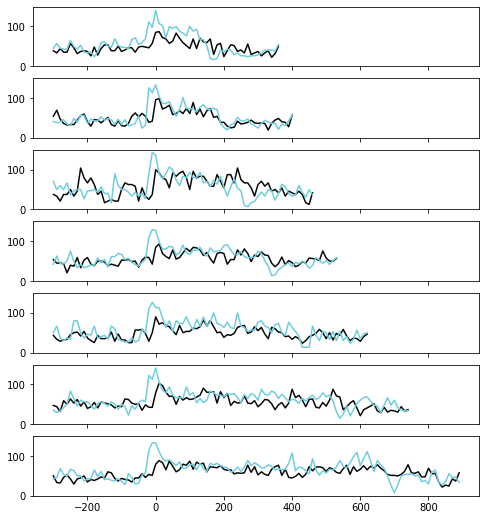

In [3]:
def normalize_to_baseline(df, background_rate_cutoff=10.):
    b = df.query("t < -60").groupby(["nid"])[["ntrials", "psth"]].sum()
    b = b["psth"] / b["ntrials"] * 100
    b.name = "background_rate"
    df = df.merge(b.to_frame(), how="left", on="nid", validate="many_to_one")
    df = df[df.background_rate >= background_rate_cutoff]
    df.loc[:, "psth"] = df.psth / (df.background_rate / 100 * df.ntrials) - 1
    return df


def plot_psth(df, groupby=['T2', 'light', 't'], normalize_baseline=False,
              background_rate_cutoff=10):
    if normalize_baseline:
        df = normalize_to_baseline(df, background_rate_cutoff)
    gb = df.groupby(groupby)
    d = gb['ntrials', 'psth'].sum()
    y = d.psth / d.ntrials * 100 # TODO remove * 100
    y.name = 'spike_prob'
    plot_groupby = [gb for gb in groupby if gb != "t"]
    if 'ppc' not in df:
        plot_df = y.to_frame().reset_index()
        plot_ppc = False
    else:
        if normalize_baseline:
            def mean_ppc(df):
                y = np.array([v/n for n, v in zip(df.ntrials, df.ppc)]).mean()
                return y / df.background_rate - 1
            def std_ppc(df):
                y = np.array([v/n for n, v in zip(df.ntrials, df.ppc)]).std()
                return y / df.background_rate
        else:
            def mean_ppc(df):
                return np.array([v/n for n, v in zip(df.ntrials, df.ppc)]).mean()
            def std_ppc(df):
                return np.array([v/n for n, v in zip(df.ntrials, df.ppc)]).std()
        pred = gb['ntrials', 'ppc'].apply(mean_ppc)
        err = gb['ntrials', 'ppc'].apply(std_ppc)
        pred.name = 'prediction'
        err.name = 'pred_err'
        plot_df = pd.concat([y, pred, err], axis=1).reset_index()
        plot_ppc = True
    if "T2" in groupby:
        uT2 = sorted(plot_df.T2.unique())
        f, axs = plt.subplots(
            len(uT2),
            1,
            sharex=True,
            sharey=True,
            figsize=(8, 9)
        )
    else:
        f, axs = plt.subplots(
            1,
            1,
            sharex=True,
            sharey=True,
            figsize=(8, 5)
        )
    colors = opto_colormap([0, 1])
    if "T2" in groupby:
        for gs, df in plot_df.groupby(plot_groupby):
            T2 = gs[plot_groupby.index("T2")]
            light = gs[plot_groupby.index("light")]
            ax = axs[uT2.index(T2)]
            color = colors[light]
            ls = '--' if plot_ppc else '-'
            ax.plot(df.t, df.spike_prob, color=color, linestyle=ls)
            if plot_ppc:
                ax.plot(df.t, df.prediction, color=color)
                ax.fill_between(
                    df.t,
                    df.prediction + df.pred_err,
                    df.prediction - df.pred_err,
                    color=color,
                    alpha=0.3
                )
    else:
        for gs, df in plot_df.groupby(plot_groupby):
            if not isinstance(gs, list):
                try:
                    gs = list(gs)
                except TypeError:
                    gs = [gs]
            light = gs[plot_groupby.index("light")]
            ax = axs
            color = colors[light]
            ls = '--' if plot_ppc else '-'
            ax.plot(df.t, df.spike_prob, color=color, linestyle=ls)
            if plot_ppc:
                ax.plot(df.t, df.prediction, color=color)
                ax.fill_between(
                    df.t,
                    df.prediction + df.pred_err,
                    df.prediction - df.pred_err,
                    color=color,
                    alpha=0.3
                )
    return f, axs

plot_psth(stacked_df.query('nid<=5'))

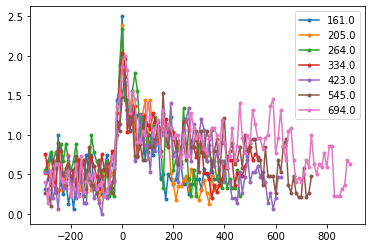

In [4]:
for g, df in stacked_df.groupby(['nid', 'T1', 'T2']):
    if g[0] == 5:
        d = df.groupby(['t'])[['ntrials','psth']].sum()
        plt.plot(d.psth/d.ntrials, '.-', label=g[2])
plt.legend()

In [5]:
df = stacked_df.query('nid <= 5')

In [6]:
t = df["t"].values
offset_t = df["offset_t"].values
psth = df["psth"].values
n = df["ntrials"].values
nid = df["nid"].values
light = df["light"].values

unid, nid_inds = np.unique(nid, return_inverse=True)
ulight, light_inds = np.unique(light, return_inverse=True)

In [7]:
with pm.Model() as model:
    link_t_model = model
    lam = pm.Gamma('lam', mu=30, sigma=5, shape=len(unid))
    tau = pm.Gamma('tau', mu=50, sigma=10,
                   shape=len(unid))
    mech_onset = pm.Normal('mech_onset', 0, sigma=10,
                           shape=len(unid))
    opto_onset = pm.Normal('opto_onset', 0, sigma=10,
                           shape=len(unid))
    tau_opto = pm.Gamma('tau_opto', mu=50, sigma=10,
                        shape=len(unid))
    tau_inh = pm.Gamma('tau_inh', mu=30, sigma=10,
                       shape=len(unid))
    I0 = pm.Normal('I0', mu=0, sigma=1., shape=len(unid))
    I1 = pm.Normal('I1', mu=0., sigma=1.,
                   shape=len(unid))
    I1p = pm.Normal('I1p', mu=0., sigma=1.,
                    shape=len(unid))
    I2 = pm.Normal('I2', mu=0., sigma=1.,
                   shape=len(unid))
    I2p = pm.Normal('I2p', mu=0., sigma=1.,
                    shape=len(unid))
    I3p = pm.Normal('I3p', mu=0., sigma=1.,
                    shape=len(unid))
    mech_w = (
        tt.nnet.sigmoid(1 * (t - mech_onset[nid_inds])) *
        tt.nnet.sigmoid(-1 * (offset_t - mech_onset[nid_inds]))
    ) * (1 - light)
    opto_w = (
        tt.nnet.sigmoid(1 * (t - opto_onset[nid_inds])) *
        tt.nnet.sigmoid(-1 * (offset_t - opto_onset[nid_inds]))
    ) * light
    opto_w2 = tt.nnet.sigmoid(1 * (offset_t - opto_onset[nid_inds])) * light
    input_current = (
        I0[nid_inds] +
        mech_w * (
            I1[nid_inds] +
            (I1p[nid_inds] - I1[nid_inds]) *
            tt.exp(- (t - mech_onset[nid_inds]) / tau[nid_inds])
        ) +
        opto_w * (
            I1[nid_inds] +
            (I1p[nid_inds] - I1[nid_inds]) *
            tt.exp(- (t - mech_onset[nid_inds]) / tau[nid_inds]) +
            I2[nid_inds] +
            (I2p[nid_inds] - I2[nid_inds]) *
            tt.exp(-(t - opto_onset[nid_inds]) / tau_opto[nid_inds])
        )
        + opto_w2 *
        I3p[nid_inds] *
        tt.exp(-(offset_t - opto_onset[nid_inds])/tau_inh[nid_inds])
    )
    io_func = tt.nnet.sigmoid(input_current) * lam[nid_inds]
    mu_t = (io_func + 1e-3) * n
    obs_psth = pm.Poisson('psth', mu=mu_t,
                          observed=psth)
    link_t_trace = trace = pm.sample(draws=2000, tune=1000, target_accept=0.85)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [I3p, I2p, I2, I1p, I1, I0, tau_inh, tau_opto, opto_onset, mech_onset, tau, lam]
Sampling 4 chains, 0 divergences:   5%|▍         | 566/12000 [01:29<30:07,  6.33draws/s]  


ValueError: Not enough samples to build a trace.

  0%|          | 1/2052 [00:00<04:55,  6.95it/s]


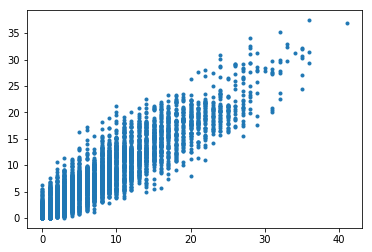

In [7]:
with model:
    ppc = pm.sample_posterior_predictive(trace)
plt.plot(psth, np.mean(ppc['psth'], axis=0), '.')

In [8]:
temp_df = stacked_df.assign(
    ppc=np.mean(ppc['psth'], axis=0),
    eppc=np.std(ppc['psth'], axis=0),
)
temp_df

ValueError: Length of values does not match length of index

In [ ]:
plot_psth(temp_df)

In [ ]:
with model:
    pm.pairplot(trace, divergences=True)

In [ ]:
with model:
    pm.traceplot(trace, divergences=True)

In [7]:
import os

In [8]:
fnames = sorted([f for f in os.listdir("simple_model_fits/")
                 if f.endswith('.gz') and f != "population_ppc.gz" and f != "behavioral_drives.gz"],
                key=lambda x: int(x.split('.')[0]))
fnames

['0.gz',
 '1.gz',
 '2.gz',
 '3.gz',
 '4.gz',
 '5.gz',
 '6.gz',
 '7.gz',
 '8.gz',
 '9.gz',
 '10.gz',
 '11.gz',
 '12.gz',
 '13.gz',
 '14.gz',
 '15.gz',
 '16.gz',
 '17.gz',
 '18.gz',
 '19.gz',
 '20.gz',
 '21.gz',
 '22.gz',
 '23.gz',
 '24.gz',
 '25.gz',
 '26.gz',
 '27.gz',
 '28.gz',
 '29.gz',
 '30.gz',
 '31.gz',
 '32.gz',
 '33.gz',
 '34.gz',
 '35.gz',
 '36.gz',
 '37.gz',
 '38.gz',
 '39.gz',
 '40.gz',
 '41.gz',
 '42.gz',
 '43.gz',
 '44.gz',
 '45.gz',
 '46.gz',
 '47.gz',
 '48.gz',
 '49.gz',
 '50.gz',
 '51.gz',
 '52.gz',
 '53.gz',
 '54.gz',
 '55.gz',
 '56.gz',
 '57.gz',
 '58.gz',
 '59.gz',
 '60.gz',
 '61.gz',
 '62.gz',
 '63.gz',
 '64.gz',
 '65.gz',
 '66.gz',
 '67.gz',
 '68.gz',
 '69.gz',
 '70.gz',
 '71.gz',
 '72.gz',
 '73.gz',
 '74.gz',
 '75.gz',
 '76.gz',
 '77.gz',
 '78.gz',
 '79.gz',
 '80.gz',
 '81.gz',
 '82.gz',
 '83.gz',
 '84.gz',
 '85.gz',
 '86.gz',
 '87.gz',
 '88.gz',
 '89.gz',
 '90.gz',
 '91.gz',
 '92.gz',
 '93.gz',
 '94.gz',
 '95.gz',
 '96.gz',
 '97.gz',
 '98.gz',
 '99.gz',
 '100.gz',

In [9]:
import simple_model

In [10]:
from compress_pickle import load, dump

In [22]:
trace = load("simple_model_fits/"+fnames[0])

In [11]:
from arviz import plot_trace
from matplotlib import pyplot as plt

Text(0.5, 0.98, 'Neuron 0')

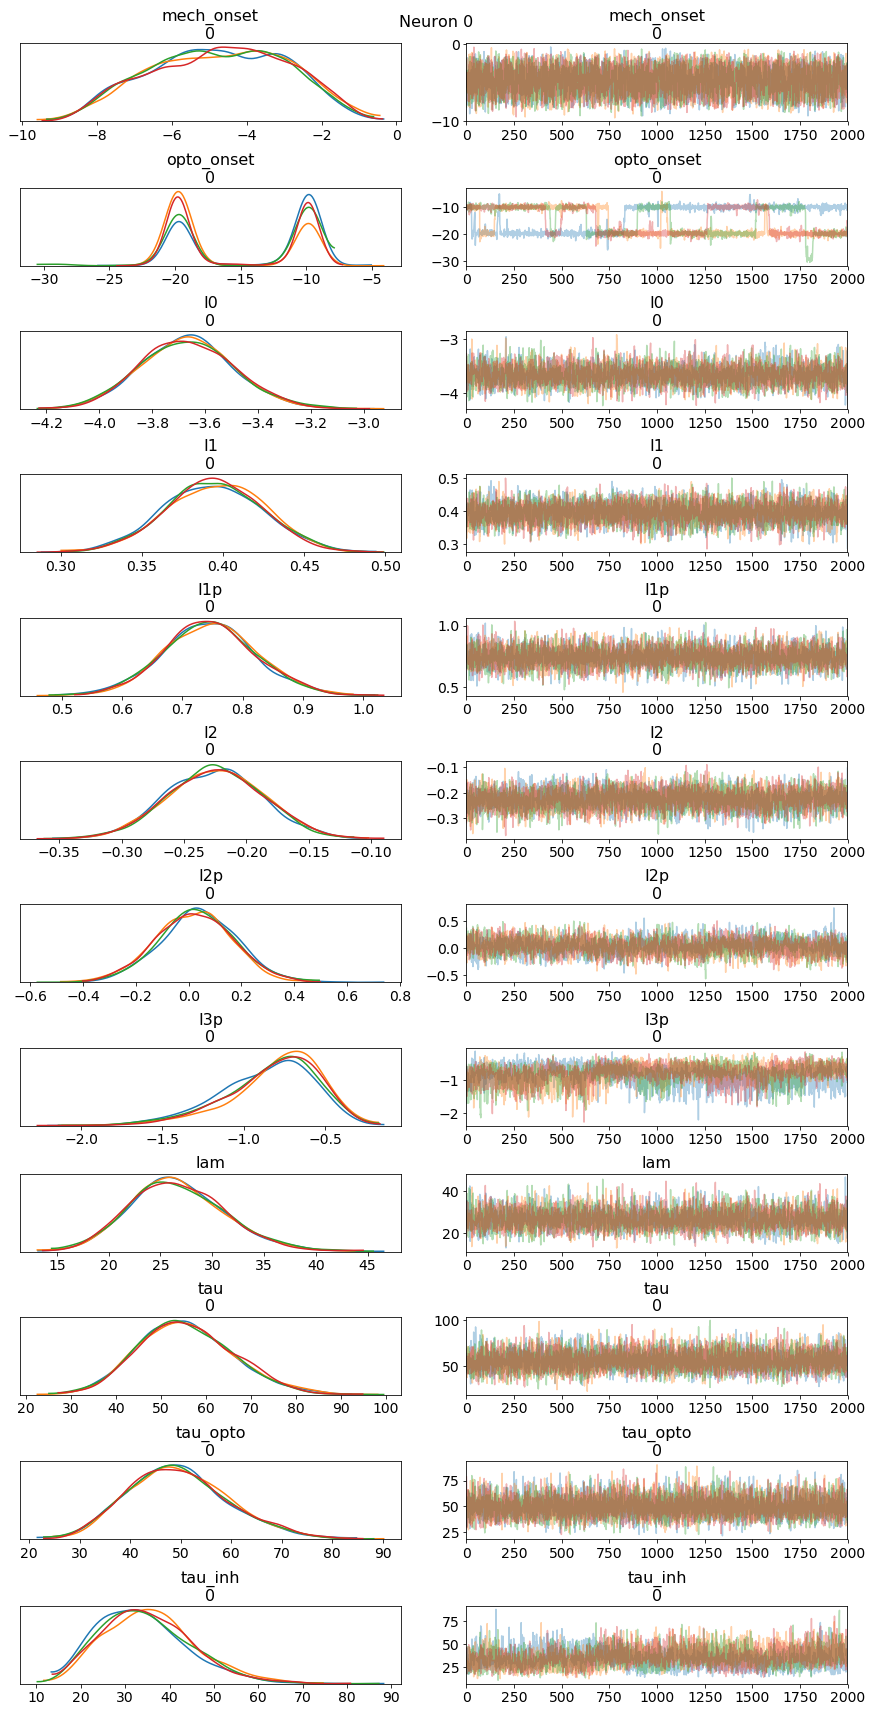

In [20]:
plot_trace(trace)
plt.suptitle('Neuron 0', fontsize=16)

In [12]:
from plot_utils import plot_ppc

In [ ]:
simple_model.load_fittable_data()
plot_ppc()

#### Cherry picked neurons

In [15]:
# Mechanical and opto neuron
nid = 4
ndf1 = stacked_df.query("nid == {} and T2 == 334".format(nid))
model = simple_model.get_training_model(ndf1)
trace = load(os.path.join("simple_model_fits", "{}.gz".format(nid)))
with model:
    ppc1 = pm.sample_posterior_predictive(trace, progressbar=False)

(-10, 350)

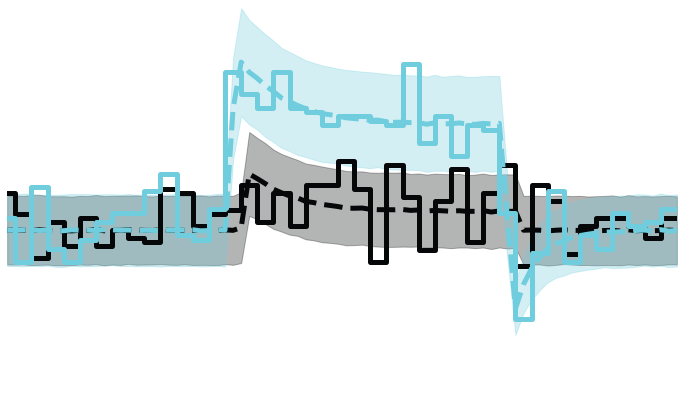

In [16]:
t, offset_t, psth, n = simple_model.get_data_arrays(ndf1)[:4]
fig = plt.figure(figsize=(12, 7))
fig, axs = plot_ppc(
    t,
    n,
    increase_psth_binsize(psth),
    ppc1["psth"],
    ndf1,
    plot_ppc_stats=True,
    axesby=[],
    groupby=["light"],
    plot_legend=False,
    linewidth=5,
    cmap=opto_colormap,
    figure=fig,
)
axs[0].axis('off')
axs[0].axis('tight')
axs[0].autoscale(enable=True, axis='x', tight=True)
axs[0].set_ylim([-10, 350])

In [17]:
# Mechanical neuron
nid = 11
ndf2 = stacked_df.query("nid == {} and T2 == 334".format(nid))
model = simple_model.get_training_model(ndf2)
trace = load(os.path.join("simple_model_fits", "{}.gz".format(nid)))
with model:
    ppc2 = pm.sample_posterior_predictive(trace, progressbar=False)

(-10, 350)

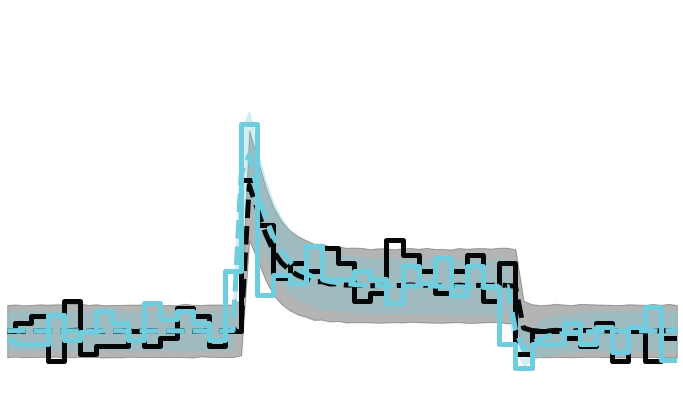

In [18]:
t, offset_t, psth, n = simple_model.get_data_arrays(ndf2)[:4]
fig = plt.figure(figsize=(12, 7))
fig, axs = plot_ppc(
    t,
    n,
    increase_psth_binsize(psth),
    ppc2["psth"],
    ndf2,
    plot_ppc_stats=True,
    axesby=[],
    groupby=["light"],
    plot_legend=False,
    linewidth=5,
    cmap=opto_colormap,
    figure=fig,
)
axs[0].axis('off')
axs[0].axis('tight')
axs[0].autoscale(enable=True, axis='x', tight=True)
axs[0].set_ylim([-10, 350])

In [19]:
# Opto neuron
nid = 221
ndf3 = stacked_df.query("nid == {} and T2 == 334".format(nid))
model = simple_model.get_training_model(ndf3)
trace = load(os.path.join("simple_model_fits", "{}.gz".format(nid)))
with model:
    ppc3 = pm.sample_posterior_predictive(trace, progressbar=False)

(-10, 350)

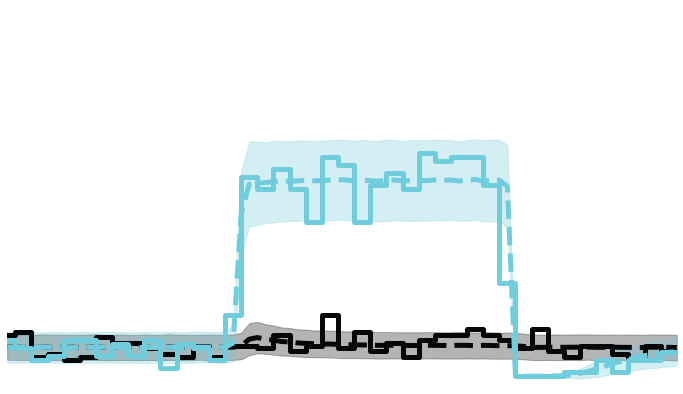

In [20]:
t, offset_t, psth, n = simple_model.get_data_arrays(ndf3)[:4]
fig = plt.figure(figsize=(12, 7))
fig, axs = plot_ppc(
    t,
    n,
    increase_psth_binsize(psth),
    ppc3["psth"],
    ndf3,
    plot_ppc_stats=True,
    axesby=[],
    groupby=["light"],
    plot_legend=False,
    linewidth=5,
    cmap=opto_colormap,
    figure=fig,
)
axs[0].axis('off')
axs[0].axis('tight')
axs[0].autoscale(enable=True, axis='x', tight=True)
axs[0].set_ylim([-10, 350])

In [21]:
# Unresponsive neuron
nid = 226
ndf4 = stacked_df.query("nid == {} and T2 == 334".format(nid))
model = simple_model.get_training_model(ndf4)
trace = load(os.path.join("simple_model_fits", "{}.gz".format(nid)))
with model:
    ppc4 = pm.sample_posterior_predictive(trace, progressbar=False)

(-10, 350)

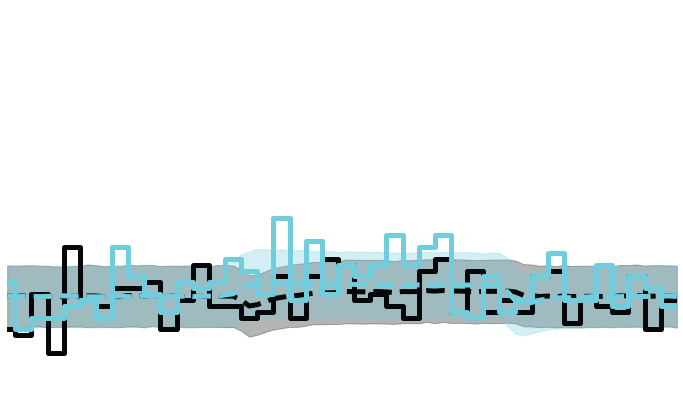

In [22]:
t, offset_t, psth, n = simple_model.get_data_arrays(ndf4)[:4]
fig = plt.figure(figsize=(12, 7))
fig, axs = plot_ppc(
    t,
    n,
    increase_psth_binsize(psth),
    ppc4["psth"],
    ndf4,
    plot_ppc_stats=True,
    axesby=[],
    groupby=["light"],
    plot_legend=False,
    linewidth=5,
    cmap=opto_colormap,
    figure=fig,
)
axs[0].axis('off')
axs[0].axis('tight')
axs[0].autoscale(enable=True, axis='x', tight=True)
axs[0].set_ylim([-10, 350])

In [32]:
pm.traceplot?

In [33]:
trace["lam_log__"] = trace["lam_log__"].reshape((-1, 1))

TypeError: 'MultiTrace' object does not support item assignment

In [27]:
pm.trace_to_dataframe(trace).corr()

mech_onset__0  opto_onset__0     I0__0     I1__0    I1p__0  \
mech_onset__0       1.000000      -0.023773 -0.026859 -0.067506  0.004166   
opto_onset__0      -0.023773       1.000000  0.014885 -0.113520 -0.030371   
I0__0              -0.026859       0.014885  1.000000  0.043708  0.066096   
I1__0              -0.067506      -0.113520  0.043708  1.000000 -0.010056   
I1p__0              0.004166      -0.030371  0.066096 -0.010056  1.000000   
I2__0               0.054433      -0.218649 -0.029352 -0.446027  0.156920   
I2p__0             -0.119042       0.344812 -0.011017  0.137958 -0.619462   
I3p__0              0.010532      -0.601910 -0.017267  0.114447  0.018281   
lam                 0.027243       0.005788 -0.987079 -0.097539 -0.085047   
tau__0             -0.028094      -0.126582 -0.028461 -0.239834 -0.220002   
tau_opto__0         0.009684      -0.079891  0.003915  0.047566 -0.031824   
tau_inh__0          0.022904      -0.495650  0.011743 -0.021891 -0.012882   

                  I2__0    I2p__0    I3p__0       lam    tau__0  tau_opto__0  \
mech_onset__0  0.054433 -0.119042  0.010532  0.027243 -0.028094     0.009684   
opto_onset__0 -0.218649  0.344812 -0.601910  0.005788 -0.126582    -0.079891   
I0__0         -0.029352 -0.011017 -0.017267 -0.987079 -0.028461     0.003915   
I1__0         -0.446027  0.137958  0.114447 -0.097539 -0.239834     0.047566   
I1p__0         0.156920 -0.619462  0.018281 -0.085047 -0.220002    -0.031824   
I2__0          1.000000 -0.333939  0.124607  0.024760  0.012866    -0.124015   
I2p__0        -0.333939  1.000000 -0.218246  0.015962 -0.023833    -0.142010   
I3p__0         0.124607 -0.218246  1.000000 -0.006324  0.096884     0.063258   
lam            0.024760  0.015962 -0.006324  1.000000  0.027526    -0.005216   
tau__0         0.012866 -0.023833  0.096884  0.027526  1.000000    -0.018866   
tau_opto__0   -0.124015 -0.142010  0.063258 -0.005216 -0.018866     1.000000   
tau_inh__0     0.103975 -0.194048  0.625687 -0.011766  0.071271     0.054054   

               tau_inh__0  
mech_onset__0    0.022904  
opto_onset__0   -0.495650  
I0__0            0.011743  
I1__0           -0.021891  
I1p__0          -0.012882  
I2__0            0.103975  
I2p__0          -0.194048  
I3p__0           0.625687  
lam             -0.011766  
tau__0           0.071271  
tau_opto__0      0.054054  
tau_inh__0       1.000000

In [120]:
df = (pm.trace_to_dataframe(trace).
     agg([np.mean, np.std]).
     rename(columns=lambda x: x.split("__0")[0]).
     unstack().to_frame().T)
df.assign(nid=2).set_index("nid")
# df2 = df.set_index(pd.MultiIndex.from_product([df.index.values, ["mean"]])).T
# df2

mech_onset           opto_onset                  I0                 I1  \
          mean       std       mean       std      mean      std      mean   
nid                                                                          
2    -4.741068  1.795103 -15.032223  5.031636 -3.667155  0.17849  0.394207   

                    I1p              ...           I3p                 lam  \
          std      mean       std    ...          mean       std      mean   
nid                                  ...                                     
2    0.030057  0.744705  0.076634    ...     -0.831672  0.284199  26.62638   

                     tau              tau_opto             tau_inh             
          std       mean        std       mean       std      mean        std  
nid                                                                            
2    4.589465  55.445483  10.444124  49.553688  9.959946  34.69423  10.169665  

[1 rows x 24 columns]

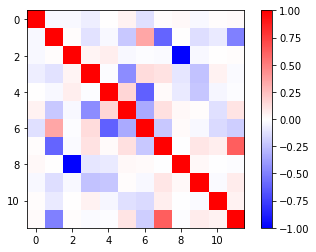

In [29]:
plt.imshow(pm.trace_to_dataframe(trace).corr(), vmin=-1, vmax=1, cmap="bwr")
plt.colorbar()

In [30]:
df = pm.trace_to_dataframe(trace)

In [14]:
df = load("simple_model_fits/significant.pkl")
df.mean()

nid     119.500000
I1        0.688551
I1p       0.753978
I2        0.430432
I2p       0.500810
I3p       0.377483
mech      0.679167
opto      0.400000
resp      0.775000
dtype: float64

In [15]:
df

nid        I1       I1p        I2       I2p       I3p   mech  opto  \
0      0.0  1.000000  1.000000  0.000000  0.474000  0.000000   True  True   
1      1.0  1.000000  1.000000  0.000000  0.118875  0.000000   True  True   
2      2.0  1.000000  1.000000  0.000000  0.747500  0.005375   True  True   
3      3.0  0.393500  0.044875  0.999625  0.828875  0.408000  False  True   
4      4.0  1.000000  1.000000  1.000000  1.000000  0.000000   True  True   
..     ...       ...       ...       ...       ...       ...    ...   ...   
235  235.0  1.000000  1.000000  0.018375  0.973875  0.000000   True  True   
236  236.0  0.468250  0.980875  0.000000  0.910000  0.000000  False  True   
237  237.0  0.999875  1.000000  1.000000  0.999625  0.000000   True  True   
238  238.0  0.001000  0.864750  0.999875  0.756375  0.059750   True  True   
239  239.0  0.000000  0.409125  1.000000  0.997875  0.000000   True  True   

     resp  
0    True  
1    True  
2    True  
3    True  
4    True  
..    ...  
235  True  
236  True  
237  True  
238  True  
239  True  

[240 rows x 9 columns]

In [16]:
mech_excited = (df.I1 >= 0.9975) | (df.I1p >= 0.9975)
opto_excited = (df.I2 >= 0.9975) | (df.I2p >= 0.9975)
not_mech_opto_excited = (np.logical_not(df.mech.values) & opto_excited)
both_mech_opto_excited = np.logical_and(df.mech, opto_excited)
print(mech_excited.mean(), opto_excited.mean(), both_mech_opto_excited.mean())
print(not_mech_opto_excited.mean())

0.5375 0.11666666666666667 0.08333333333333333
0.03333333333333333


In [17]:
zoomed_df = pd.DataFrame(
    data=np.array([
        both_mech_opto_excited,
        not_mech_opto_excited,
    ]).T,
    index=df.nid,
    columns=[
        "both_excite",
        "light_excites",
    ],
)
zoomed_df

both_excite  light_excites
nid                              
0.0          False          False
1.0          False          False
2.0          False          False
3.0          False           True
4.0           True          False
...            ...            ...
235.0        False          False
236.0        False          False
237.0         True          False
238.0         True          False
239.0         True          False

[240 rows x 2 columns]

In [18]:
df = df.assign(mech_opto=df.mech & df.opto)
df.mean()

nid          119.500000
I1             0.688551
I1p            0.753978
I2             0.430432
I2p            0.500810
I3p            0.377483
mech           0.679167
opto           0.400000
resp           0.775000
mech_opto      0.304167
dtype: float64

In [19]:
pie_df = pd.concat(
    [(df.mech & df.opto),
    (np.logical_not(df.mech) & df.opto),
    (df.mech & np.logical_not(df.opto)),
    (np.logical_not(df.mech) & np.logical_not(df.opto))],
    axis=1
)
pie_df = pie_df.rename(
    columns={k: v for k, v in enumerate([
        "Mech and Opto",
        "Not mech but Opto",
        "Mech and not Opto",
        "neither Mech nor Opto",
    ])}
)
pie_df

Mech and Opto  Not mech but Opto  Mech and not Opto  \
0             True              False              False   
1             True              False              False   
2             True              False              False   
3            False               True              False   
4             True              False              False   
..             ...                ...                ...   
235           True              False              False   
236          False               True              False   
237           True              False              False   
238           True              False              False   
239           True              False              False   

     neither Mech nor Opto  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  
..                     ...  
235                  False  
236                  False  
237                  False  
238                  False  
239                  False  

[240 rows x 4 columns]

In [20]:
seb_df = stacked_df.join(pie_df, on='nid')
seb_df

nid  mech_resp  opto_resp  single_unit     T1     T2  light  ntrials  \
0         0          0          1            0  334.0  161.0      0        9   
1         0          0          1            0  334.0  161.0      0        9   
2         0          0          1            0  334.0  161.0      0        9   
3         0          0          1            0  334.0  161.0      0        9   
4         0          0          1            0  334.0  161.0      0        9   
...     ...        ...        ...          ...    ...    ...    ...      ...   
264269  239          0          1            0  334.0  694.0      1       20   
264270  239          0          1            0  334.0  694.0      1       20   
264271  239          0          1            0  334.0  694.0      1       20   
264272  239          0          1            0  334.0  694.0      1       20   
264273  239          0          1            0  334.0  694.0      1       20   

        psth      t  offset_t  Mech and Opto  Not mech but Opto  \
0        5.0 -300.0    -470.0           True              False   
1        3.0 -290.0    -460.0           True              False   
2        5.0 -280.0    -450.0           True              False   
3        5.0 -270.0    -440.0           True              False   
4        4.0 -260.0    -430.0           True              False   
...      ...    ...       ...            ...                ...   
264269   5.0  850.0     150.0           True              False   
264270   6.0  860.0     160.0           True              False   
264271   5.0  870.0     170.0           True              False   
264272   2.0  880.0     180.0           True              False   
264273   4.0  890.0     190.0           True              False   

        Mech and not Opto  neither Mech nor Opto  
0                   False                  False  
1                   False                  False  
2                   False                  False  
3                   False                  False  
4                   False                  False  
...                   ...                    ...  
264269              False                  False  
264270              False                  False  
264271              False                  False  
264272              False                  False  
264273              False                  False  

[264274 rows x 15 columns]

Text(0, 0.5, 'Mean firing rate [Hz]')

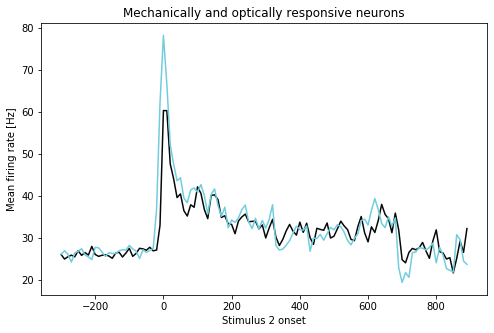

In [21]:
f, axs = plot_psth(seb_df[seb_df["Mech and Opto"]], groupby=["light", "t"])
axs.set_title('Mechanically and optically responsive neurons')
axs.set_xlabel('Stimulus 2 onset')
axs.set_ylabel('Mean firing rate [Hz]')

Text(0, 0.5, 'Mean firing rate [Hz]')

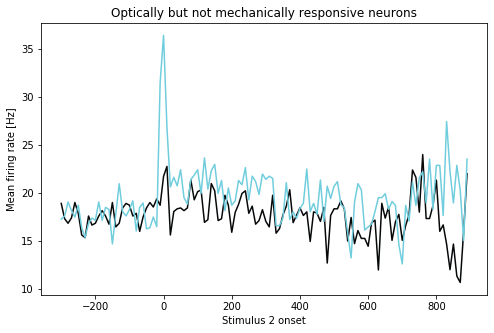

In [22]:
f, axs = plot_psth(seb_df[seb_df["Not mech but Opto"]], groupby=["light", "t"])
axs.set_title('Optically but not mechanically responsive neurons')
axs.set_xlabel('Stimulus 2 onset')
axs.set_ylabel('Mean firing rate [Hz]')

Text(0, 0.5, 'Mean firing rate [Hz]')

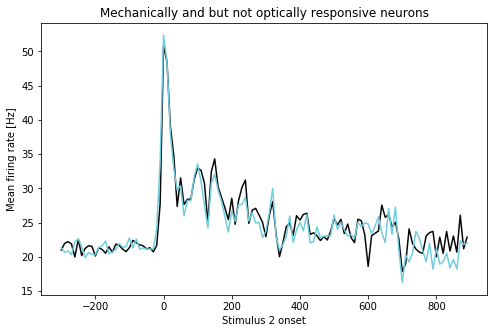

In [23]:
f, axs = plot_psth(seb_df[seb_df["Mech and not Opto"]], groupby=["light", "t"])
axs.set_title('Mechanically and but not optically responsive neurons')
axs.set_xlabel('Stimulus 2 onset')
axs.set_ylabel('Mean firing rate [Hz]')

Text(0, 0.5, 'Mean firing rate [Hz]')

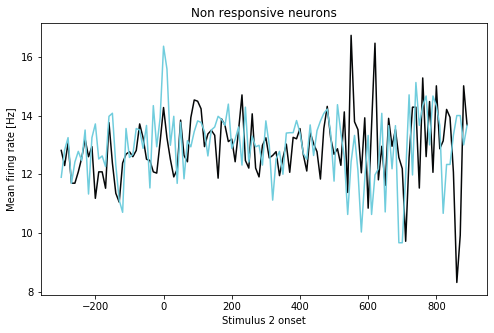

In [24]:
f, axs = plot_psth(seb_df[seb_df["neither Mech nor Opto"]], groupby=["light", "t"])
axs.set_title('Non responsive neurons')
axs.set_xlabel('Stimulus 2 onset')
axs.set_ylabel('Mean firing rate [Hz]')

#### Zooming in on the excited population only

In [25]:
seb_df2 = stacked_df.join(zoomed_df, on='nid')
seb_df2

nid  mech_resp  opto_resp  single_unit     T1     T2  light  ntrials  \
0         0          0          1            0  334.0  161.0      0        9   
1         0          0          1            0  334.0  161.0      0        9   
2         0          0          1            0  334.0  161.0      0        9   
3         0          0          1            0  334.0  161.0      0        9   
4         0          0          1            0  334.0  161.0      0        9   
...     ...        ...        ...          ...    ...    ...    ...      ...   
264269  239          0          1            0  334.0  694.0      1       20   
264270  239          0          1            0  334.0  694.0      1       20   
264271  239          0          1            0  334.0  694.0      1       20   
264272  239          0          1            0  334.0  694.0      1       20   
264273  239          0          1            0  334.0  694.0      1       20   

        psth      t  offset_t  both_excite  light_excites  
0        5.0 -300.0    -470.0        False          False  
1        3.0 -290.0    -460.0        False          False  
2        5.0 -280.0    -450.0        False          False  
3        5.0 -270.0    -440.0        False          False  
4        4.0 -260.0    -430.0        False          False  
...      ...    ...       ...          ...            ...  
264269   5.0  850.0     150.0         True          False  
264270   6.0  860.0     160.0         True          False  
264271   5.0  870.0     170.0         True          False  
264272   2.0  880.0     180.0         True          False  
264273   4.0  890.0     190.0         True          False  

[264274 rows x 13 columns]

Text(0, 0.5, 'Mean firing rate [Hz]')

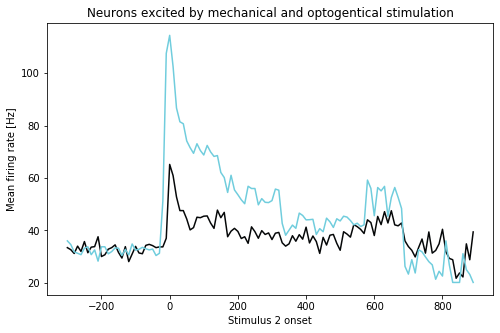

In [26]:
f, axs = plot_psth(seb_df2[seb_df2["both_excite"]], groupby=["light", "t"], normalize_baseline=False)
axs.set_title('Neurons excited by mechanical and optogentical stimulation')
axs.set_xlabel('Stimulus 2 onset')
axs.set_ylabel('Mean firing rate [Hz]')

Text(0, 0.5, 'Mean firing rate [Hz]')

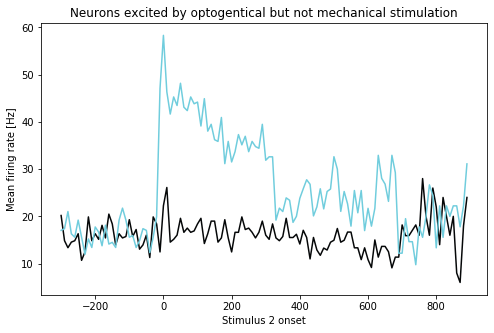

In [27]:
f, axs = plot_psth(seb_df2[seb_df2["light_excites"]], groupby=["light", "t"], normalize_baseline=False)
axs.set_title('Neurons excited by optogentical but not mechanical stimulation')
axs.set_xlabel('Stimulus 2 onset')
axs.set_ylabel('Mean firing rate [Hz]')

Text(0, 0.5, 'Mean firing rate normalized to baseline')

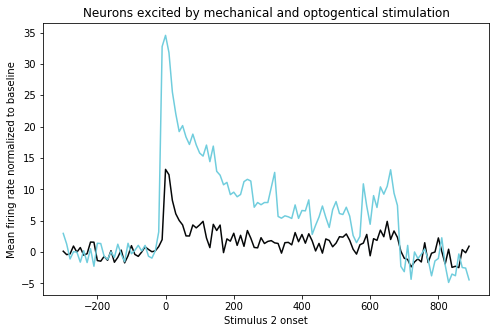

In [28]:
f, axs = plot_psth(seb_df2[seb_df2["both_excite"]], groupby=["light", "t"], normalize_baseline=True)
axs.set_title('Neurons excited by mechanical and optogentical stimulation')
axs.set_xlabel('Stimulus 2 onset')
axs.set_ylabel('Mean firing rate normalized to baseline')

Text(0, 0.5, 'Mean firing rate normalized to baseline')

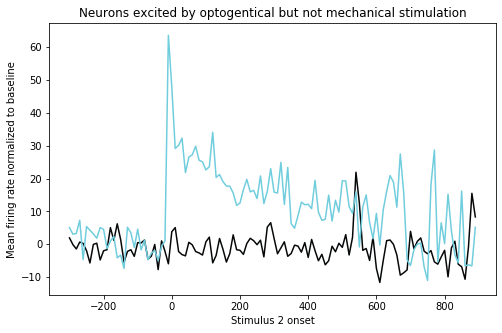

In [29]:
f, axs = plot_psth(seb_df2[seb_df2["light_excites"]], groupby=["light", "t"], normalize_baseline=True)
axs.set_title('Neurons excited by optogentical but not mechanical stimulation')
axs.set_xlabel('Stimulus 2 onset')
axs.set_ylabel('Mean firing rate normalized to baseline')

#### Statistics on jump

In [30]:
df_both = normalize_to_baseline(seb_df2[seb_df2["both_excite"]])
df_light = normalize_to_baseline(seb_df2[seb_df2["light_excites"]])
print("Total {} neurons: {}".format(len(df_both.nid.unique()), df_both.nid.unique()))
print("Total {} neurons: {}".format(len(df_light.nid.unique()), df_light.nid.unique()))
df_both.loc[:, "psth"] *= 100 / df_both.ntrials
df_light.loc[:, "psth"] *= 100 / df_light.ntrials

Total 16 neurons: [  4   5   8   9  41  43 111 173 190 200 222 228 232 237 238 239]
Total 4 neurons: [ 12 169 221 227]


In [31]:
jump_both = (
    df_both.
    query("t >=0 and t<=60").
    groupby(["nid"]).
    apply(lambda x: x.query("light == 1")["psth"].mean() - x.query("light == 0")["psth"].mean())
)
jump_light = (
    df_light.
    query("t >=0 and t<=60").
    groupby(["nid"]).
    apply(lambda x: x.query("light == 1")["psth"].mean() - x.query("light == 0")["psth"].mean())
)
print(jump_light)
print(jump_both)
print("{} +- {}".format(jump_both.mean(), jump_both.std()))
print("{} +- {}".format(jump_light.mean(), jump_light.std()))

nid
12      10.838174
169     -0.010414
221    164.812107
227     22.435624
dtype: float64
nid
4        9.903026
5       10.183623
8       22.904449
9       37.457214
41      -4.034729
43      28.417339
111    -10.977360
173    164.071731
190     -5.263805
200     11.191948
222     53.943986
228     25.860828
232     20.758135
237     34.474305
238      7.987412
239      5.555218
dtype: float64
25.777082465711082 +- 40.667517743638996
49.51887267521117 +- 77.40667254528522


In [32]:
from scipy import stats

print(stats.ttest_ind(jump_both.values, jump_light.values, equal_var=True))
print(stats.ttest_ind(jump_both.values, jump_light.values, equal_var=False))

Ttest_indResult(statistic=-0.8711414166798843, pvalue=0.3951474973978234)
Ttest_indResult(statistic=-0.5933012409430478, pvalue=0.5899068222945697)


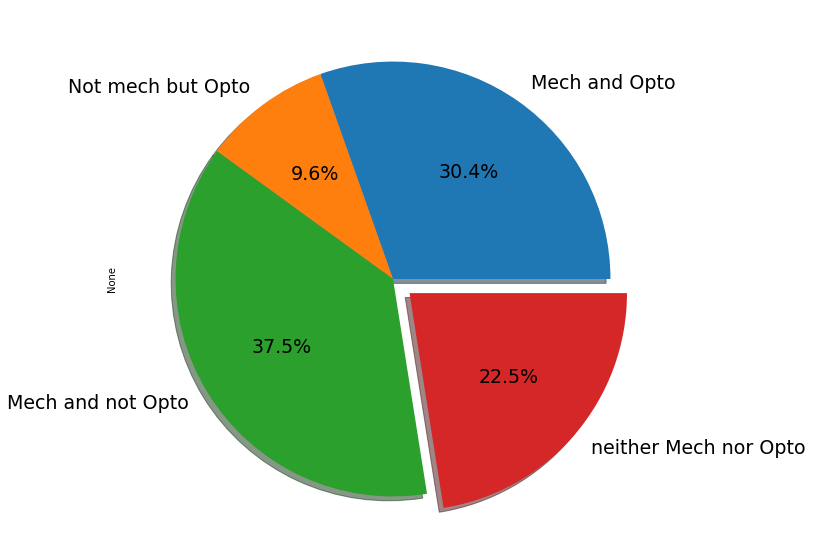

In [33]:
pie_df.mean().plot(kind="pie", autopct='%1.1f%%', figsize=(10, 10),
                   textprops={"fontsize": 19},
                   explode=[0, 0, 0, 0.1],
                   shadow=True)

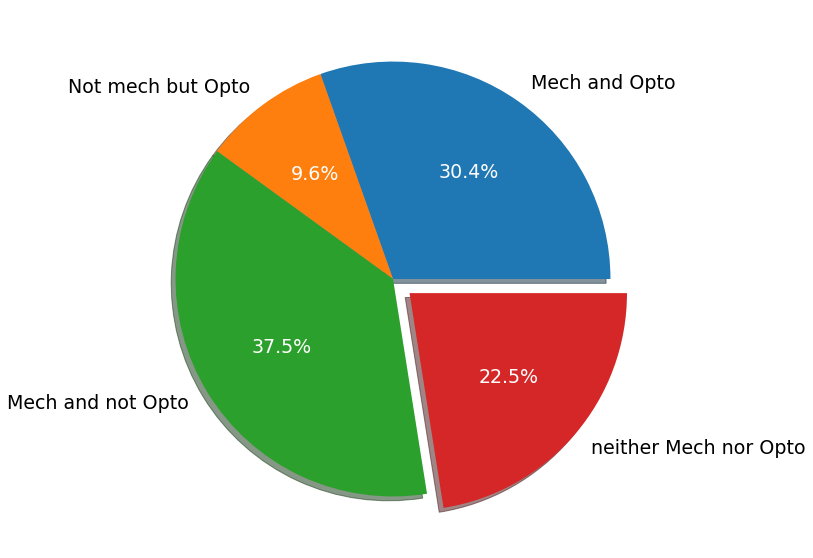

In [34]:
plt.figure(figsize=(10, 10))
_, _, autotexts = plt.pie(pie_df.mean().values,
        autopct='%1.1f%%',
        textprops={"fontsize": 19},
        explode=[0, 0, 0, 0.1],
        labels=list(pie_df.columns.values),
        labeldistance=1.1,
        shadow=True)
for a in autotexts:
    a.set_color("w");

In [35]:
pie_df.columns[[True, False, False, False]]

Index(['Mech and Opto'], dtype='object')

In [36]:
import seaborn as sns

temp = load('simple_model_fits/parameters.pkl')
viz_df = (temp.xs("mean", axis=1, level=1).
          assign(label=[pie_df.columns[v].values[0]
                  for k, v in pie_df.iterrows()
                 if k in temp.index])
         )
viz_df

mech_onset  opto_onset        I0        I1       I1p        I2       I2p  \
nid                                                                             
2     -4.872916  -24.440595  0.073049  0.111135  0.334665 -0.115774  0.138777   
4     -4.792644  -20.136572  1.180695  0.204287  0.747084  1.219649  2.289230   
5     -5.485720  -20.482960  0.448895  0.464427  1.882966  0.084404  1.279321   
6     -6.011295  -19.911243  0.576748  0.620141  2.327467 -0.088921  1.277213   
8     -4.923470  -11.289249  0.609639 -0.073354  0.570420  0.726885  2.222823   
..          ...         ...       ...       ...       ...       ...       ...   
225   28.319147  -10.662570  0.141830 -0.104249  0.346644 -0.016151 -0.578734   
226   -2.348523  -14.082944 -0.035220 -0.060882  0.031623  0.118676  0.221821   
227    5.427271  -14.191936  0.485751 -0.083764  0.290433  0.496937  0.679050   
228   -2.929010  -13.859868  0.255929 -0.119271  0.088100  0.264612  0.835375   
238    7.708643  -14.982788  0.063389 -0.056669  0.074414  0.079909  0.095607   

          I3p         nu        lam        tau   tau_opto    tau_inh  \
nid                                                                    
2   -0.160758  31.543187   2.812515  34.101042  42.408300  36.214010   
4   -0.986791  26.100035   3.804516  49.046383  50.284776  30.935058   
5   -0.450740  29.232084   3.376548  33.150966  39.362233  33.066995   
6   -0.184894  27.837618   3.680064  33.372154  35.579265  33.873393   
8   -0.974366  28.263142   3.403093  30.116517  38.273071  14.217213   
..        ...        ...        ...        ...        ...        ...   
225 -0.297270  32.987251   2.691183  60.842289  49.650135  31.782430   
226 -0.499520  44.128201  17.864929  49.038246  50.670362  28.260079   
227 -0.193337  33.798234   2.593542  54.153578  50.501580  27.224016   
228 -0.693184  32.432060   2.708928  47.289405  51.432260  30.873522   
238 -0.135379  31.969678   2.765354  43.096055  48.247125  29.750354   

                     label  
nid                         
2            Mech and Opto  
4            Mech and Opto  
5            Mech and Opto  
6        Mech and not Opto  
8            Mech and Opto  
..                     ...  
225      Mech and not Opto  
226  neither Mech nor Opto  
227      Not mech but Opto  
228          Mech and Opto  
238          Mech and Opto  

[157 rows x 14 columns]

/home/lpaz/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1306: UserWarning: tight_layout : falling back to Agg renderer
  fig.tight_layout()


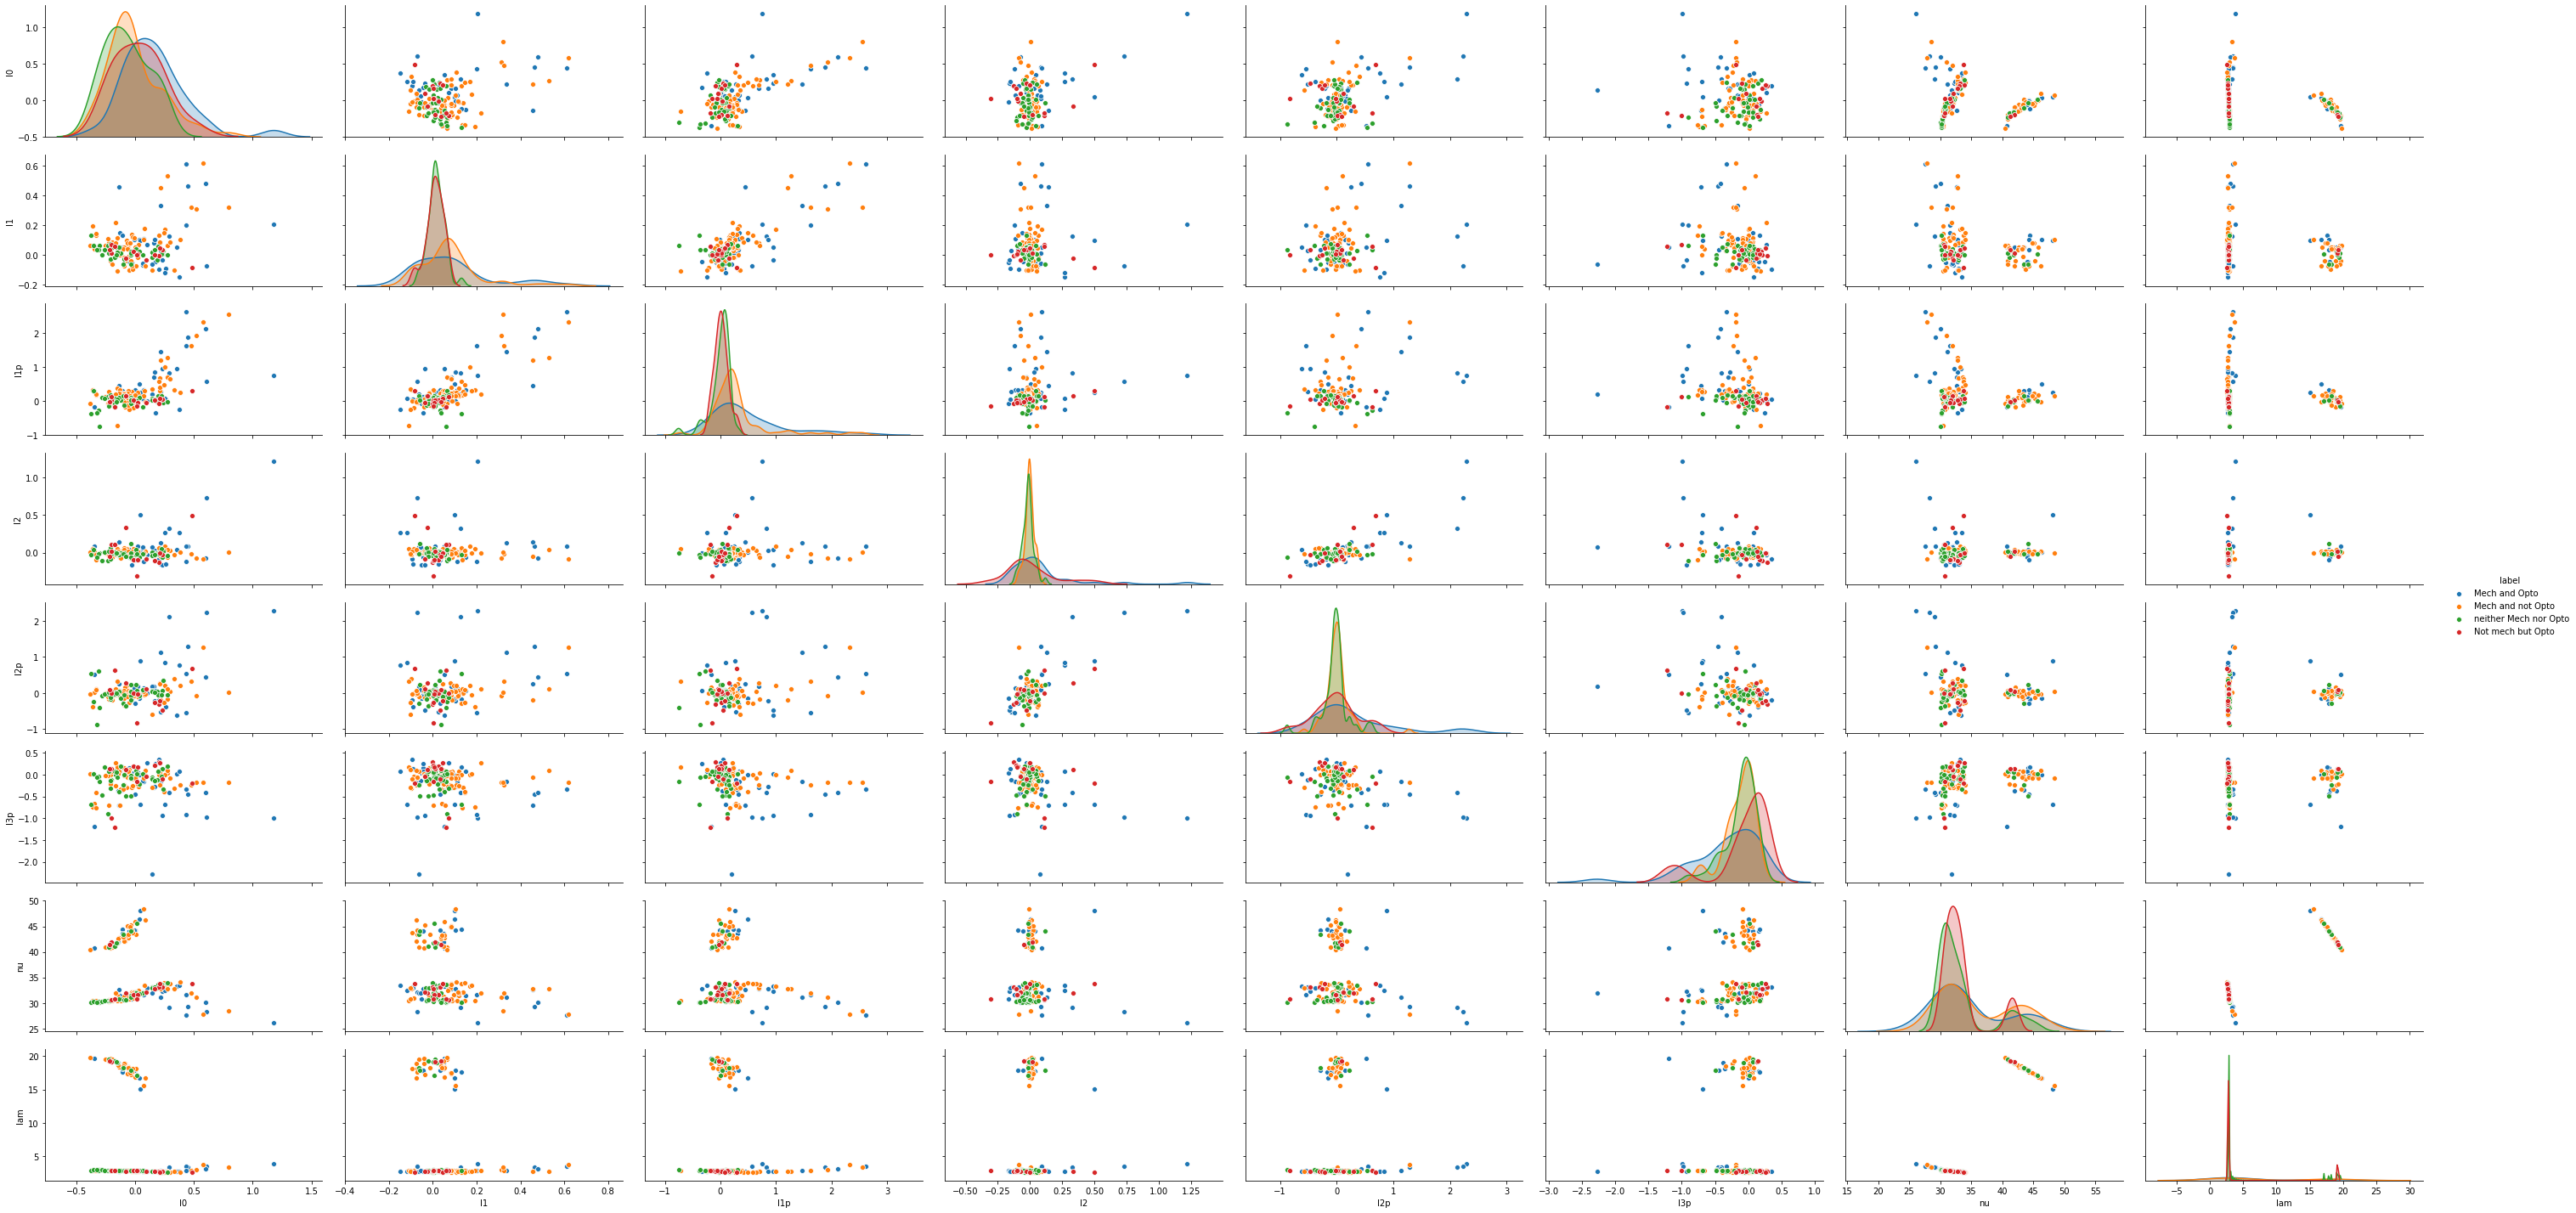

In [37]:
sns.pairplot(viz_df,
             vars=["I0", "I1", "I1p", "I2", "I2p", "I3p", "nu", "lam"],
             diag_kind='kde',
             hue="label",
             aspect=2)

In [379]:
trace1 = load("simple_model_fits/3.gz")

In [386]:
from pymc3.backends.report import WarningType

WarningType??
trace1.report._warnings[0][0] == WarningType.DIVERGENCE

True

In [38]:
df = load("simple_model_fits/parameters.pkl")
df

mech_onset            opto_onset                   I0                  I1  \
          mean        std       mean        std      mean       std      mean   
nid                                                                             
2    -4.872916   3.060146 -24.440595   2.022857  0.073049  0.038472  0.111135   
4    -4.792644   2.406656 -20.136572   0.319960  1.180695  0.177700  0.204287   
5    -5.485720   2.364652 -20.482960   0.370547  0.448895  0.076298  0.464427   
6    -6.011295   2.034919 -19.911243   0.405707  0.576748  0.090847  0.620141   
8    -4.923470   2.294339 -11.289249   1.095016  0.609639  0.101738 -0.073354   
..         ...        ...        ...        ...       ...       ...       ...   
225  28.319147   6.797994 -10.662570  12.487806  0.141830  0.047936 -0.104249   
226  -2.348523   7.316443 -14.082944   1.907762 -0.035220  0.052758 -0.060882   
227   5.427271  13.733527 -14.191936   2.301510  0.485751  0.107333 -0.083764   
228  -2.929010   7.416320 -13.859868   1.842572  0.255929  0.062161 -0.119271   
238   7.708643   7.796713 -14.982788   2.632829  0.063389  0.038412 -0.056669   

                    I1p            ...         nu                   lam  \
          std      mean       std  ...       mean        std       mean   
nid                                ...                                    
2    0.020808  0.334665  0.112762  ...  31.543187   5.238604   2.812515   
4    0.048467  0.747084  0.213613  ...  26.100035   4.139985   3.804516   
5    0.083891  1.882966  0.447065  ...  29.232084   4.492953   3.376548   
6    0.106669  2.327467  0.537390  ...  27.837618   4.238761   3.680064   
8    0.023689  0.570420  0.199502  ...  28.263142   4.386368   3.403093   
..        ...       ...       ...  ...        ...        ...        ...   
225  0.027675  0.346644  0.105507  ...  32.987251   5.305488   2.691183   
226  0.013299  0.031623  0.050298  ...  44.128201  10.917179  17.864929   
227  0.039450  0.290433  0.150468  ...  33.798234   5.208475   2.593542   
228  0.028976  0.088100  0.119772  ...  32.432060   5.047056   2.708928   
238  0.018296  0.074414  0.069925  ...  31.969678   5.270520   2.765354   

                     tau              tau_opto               tau_inh  \
          std       mean        std       mean        std       mean   
nid                                                                    
2    0.403524  34.101042   9.422612  42.408300  10.324986  36.214010   
4    0.294599  49.046383  10.073992  50.284776   9.643060  30.935058   
5    0.333540  33.150966   6.521752  39.362233   9.064874  33.066995   
6    0.320588  33.372154   6.175796  35.579265   9.290787  33.873393   
8    0.331880  30.116517   7.013941  38.273071   7.316082  14.217213   
..        ...        ...        ...        ...        ...        ...   
225  0.398676  60.842289   8.774078  49.650135   9.244220  31.782430   
226  4.923248  49.038246   9.776411  50.670362  10.185079  28.260079   
227  0.372692  54.153578   9.639670  50.501580  10.405648  27.224016   
228  0.378976  47.289405   9.724697  51.432260   9.940549  30.873522   
238  0.397247  43.096055  10.180263  48.247125   9.959284  29.750354   

                
           std  
nid             
2    10.427599  
4     5.849540  
5     6.784530  
6     9.557514  
8     3.021245  
..         ...  
225  11.340568  
226   8.127287  
227   9.751576  
228   8.588242  
238   9.768294  

[157 rows x 26 columns]

In [39]:
df.xs("mean", axis=1, level=1)

mech_onset  opto_onset        I0        I1       I1p        I2       I2p  \
nid                                                                             
2     -4.872916  -24.440595  0.073049  0.111135  0.334665 -0.115774  0.138777   
4     -4.792644  -20.136572  1.180695  0.204287  0.747084  1.219649  2.289230   
5     -5.485720  -20.482960  0.448895  0.464427  1.882966  0.084404  1.279321   
6     -6.011295  -19.911243  0.576748  0.620141  2.327467 -0.088921  1.277213   
8     -4.923470  -11.289249  0.609639 -0.073354  0.570420  0.726885  2.222823   
..          ...         ...       ...       ...       ...       ...       ...   
225   28.319147  -10.662570  0.141830 -0.104249  0.346644 -0.016151 -0.578734   
226   -2.348523  -14.082944 -0.035220 -0.060882  0.031623  0.118676  0.221821   
227    5.427271  -14.191936  0.485751 -0.083764  0.290433  0.496937  0.679050   
228   -2.929010  -13.859868  0.255929 -0.119271  0.088100  0.264612  0.835375   
238    7.708643  -14.982788  0.063389 -0.056669  0.074414  0.079909  0.095607   

          I3p         nu        lam        tau   tau_opto    tau_inh  
nid                                                                   
2   -0.160758  31.543187   2.812515  34.101042  42.408300  36.214010  
4   -0.986791  26.100035   3.804516  49.046383  50.284776  30.935058  
5   -0.450740  29.232084   3.376548  33.150966  39.362233  33.066995  
6   -0.184894  27.837618   3.680064  33.372154  35.579265  33.873393  
8   -0.974366  28.263142   3.403093  30.116517  38.273071  14.217213  
..        ...        ...        ...        ...        ...        ...  
225 -0.297270  32.987251   2.691183  60.842289  49.650135  31.782430  
226 -0.499520  44.128201  17.864929  49.038246  50.670362  28.260079  
227 -0.193337  33.798234   2.593542  54.153578  50.501580  27.224016  
228 -0.693184  32.432060   2.708928  47.289405  51.432260  30.873522  
238 -0.135379  31.969678   2.765354  43.096055  48.247125  29.750354  

[157 rows x 13 columns]

In [40]:
import seaborn as sns

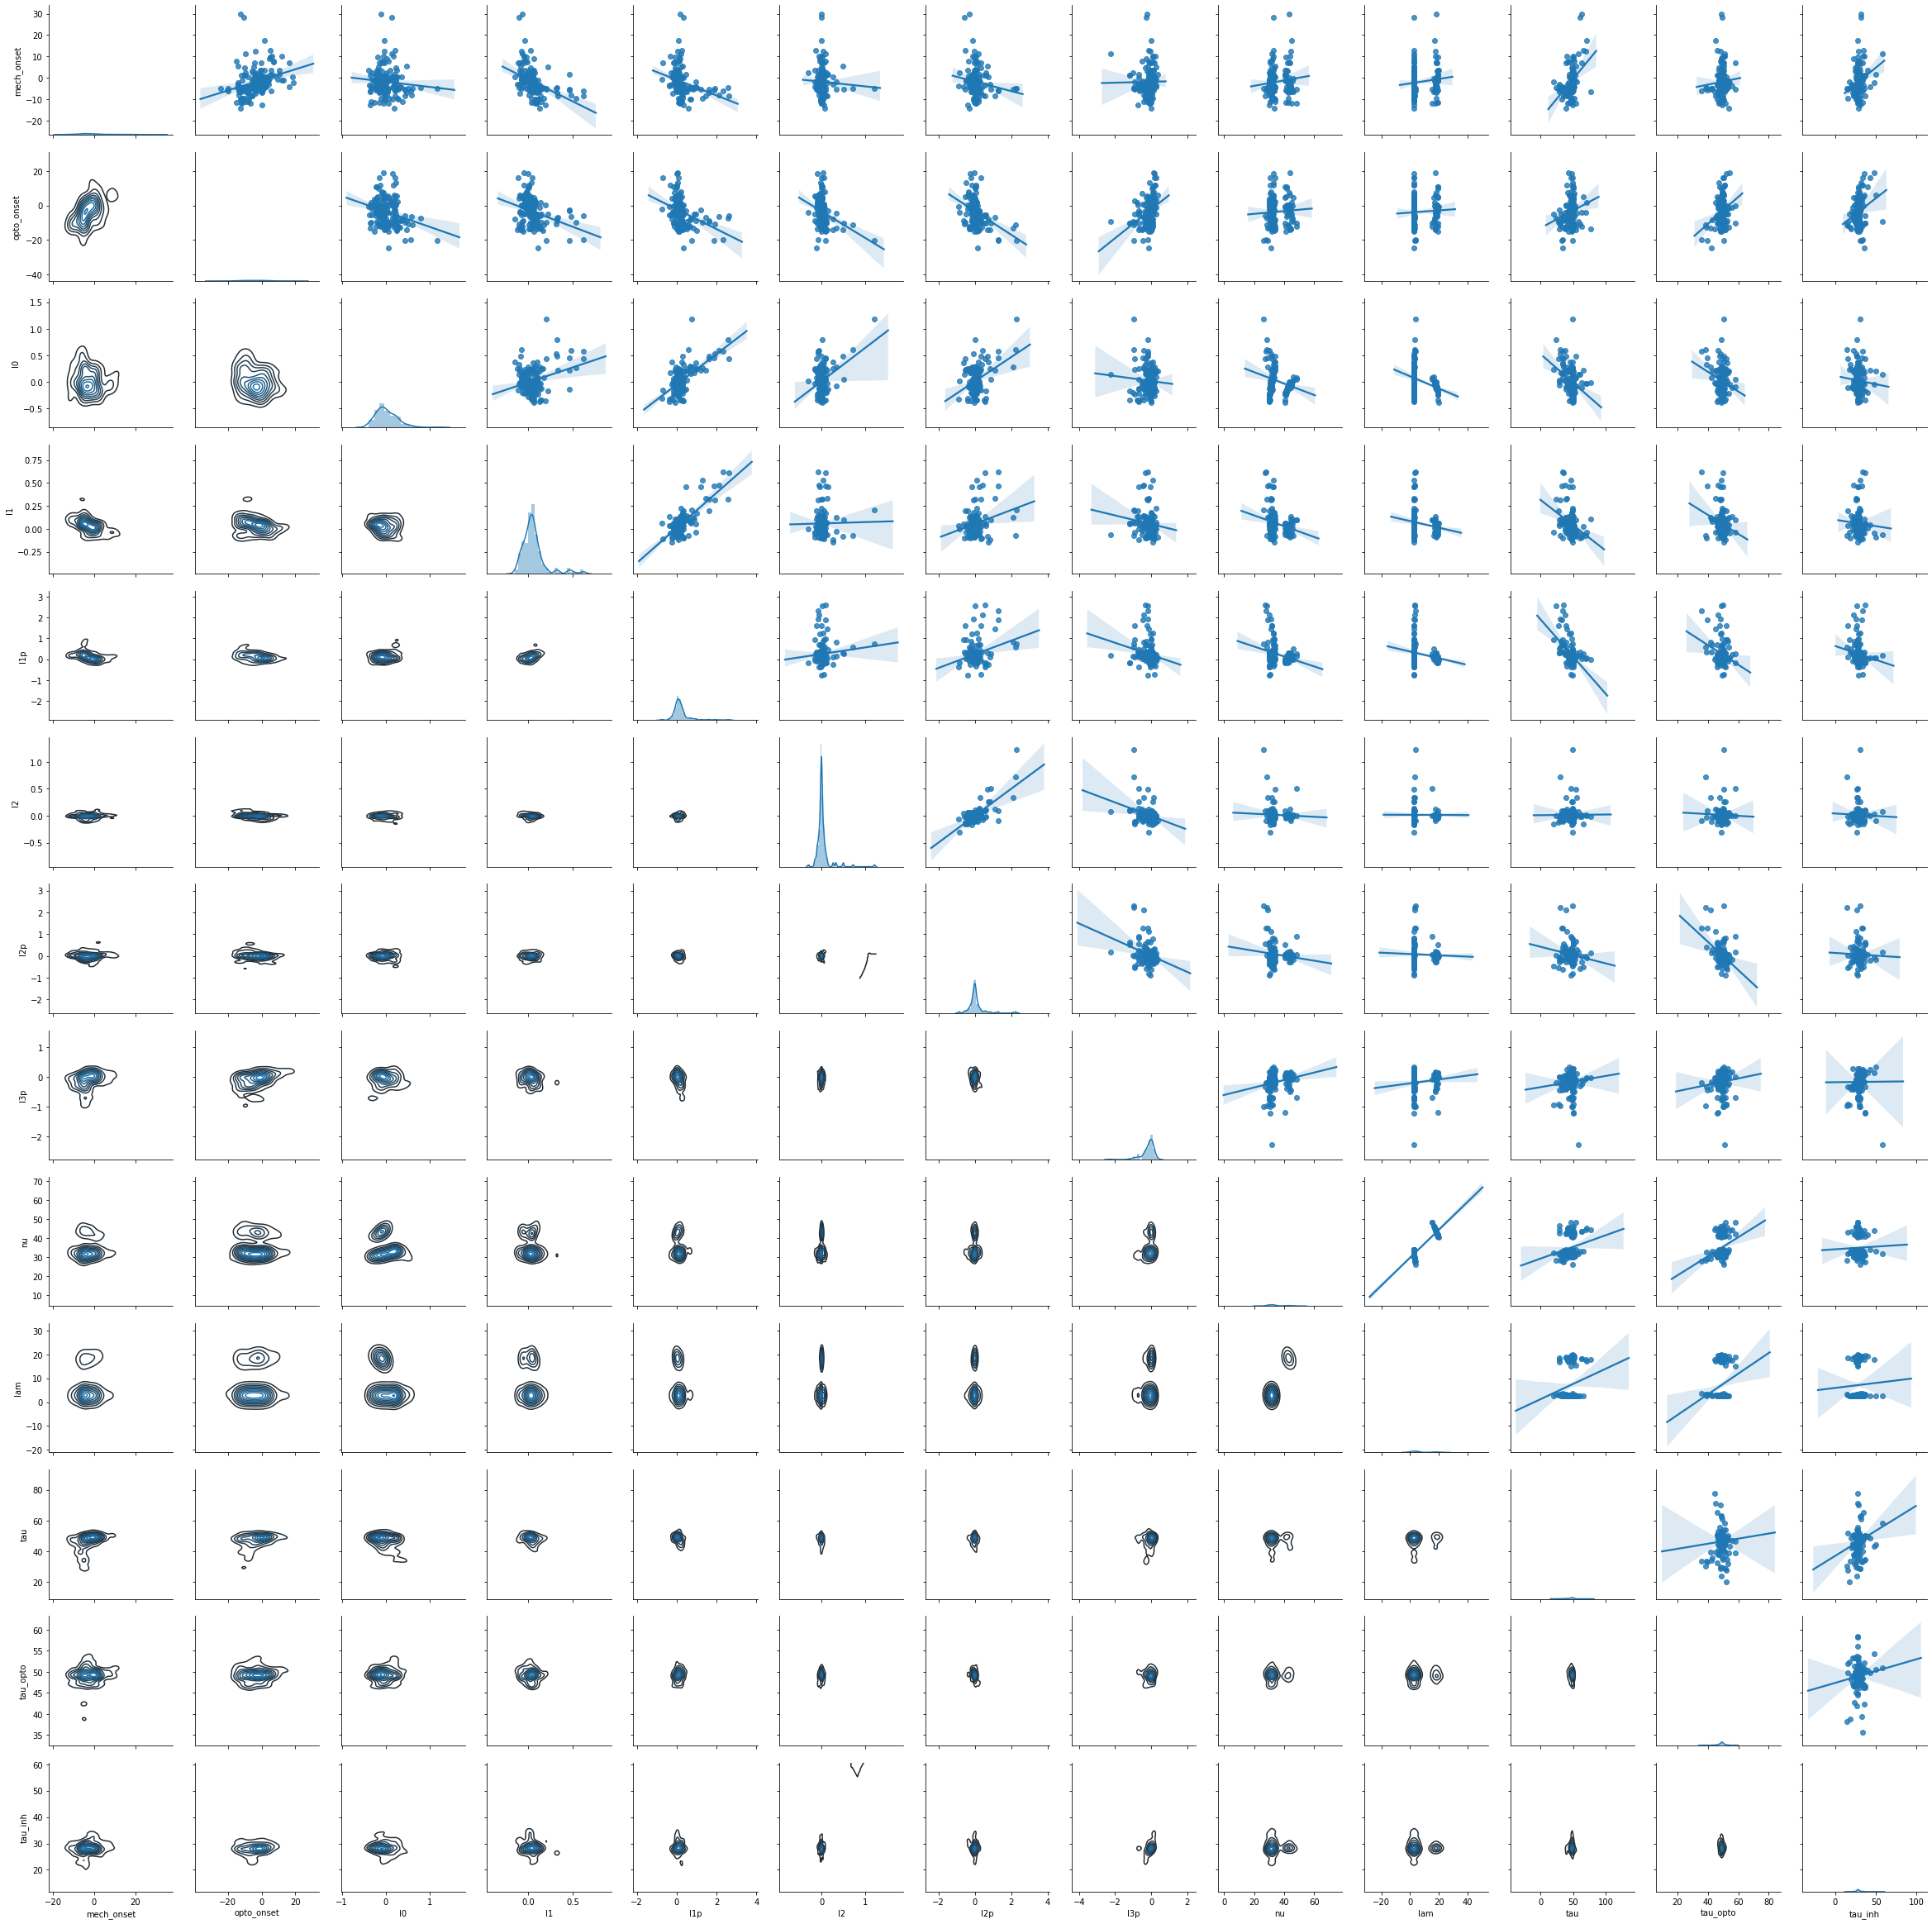

In [50]:
g = sns.PairGrid(data=df.xs("mean", axis=1, level=1))
g.map_lower(sns.kdeplot)
g.map_upper(sns.regplot)
g.map_diag(sns.distplot)

In [41]:
from sklearn.mixture import BayesianGaussianMixture

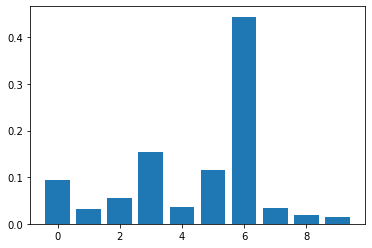

In [52]:
gmm = BayesianGaussianMixture(
    n_components=10,
    covariance_type='full',
    n_init=5,
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=1e-6,
)
train_df = df.xs("mean", axis=1, level=1)
label = pd.Series(data=gmm.fit_predict(train_df), index=train_df.index)
plt.bar(range(len(gmm.weights_)), gmm.weights_);

/home/lpaz/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1306: UserWarning: tight_layout : falling back to Agg renderer
  fig.tight_layout()


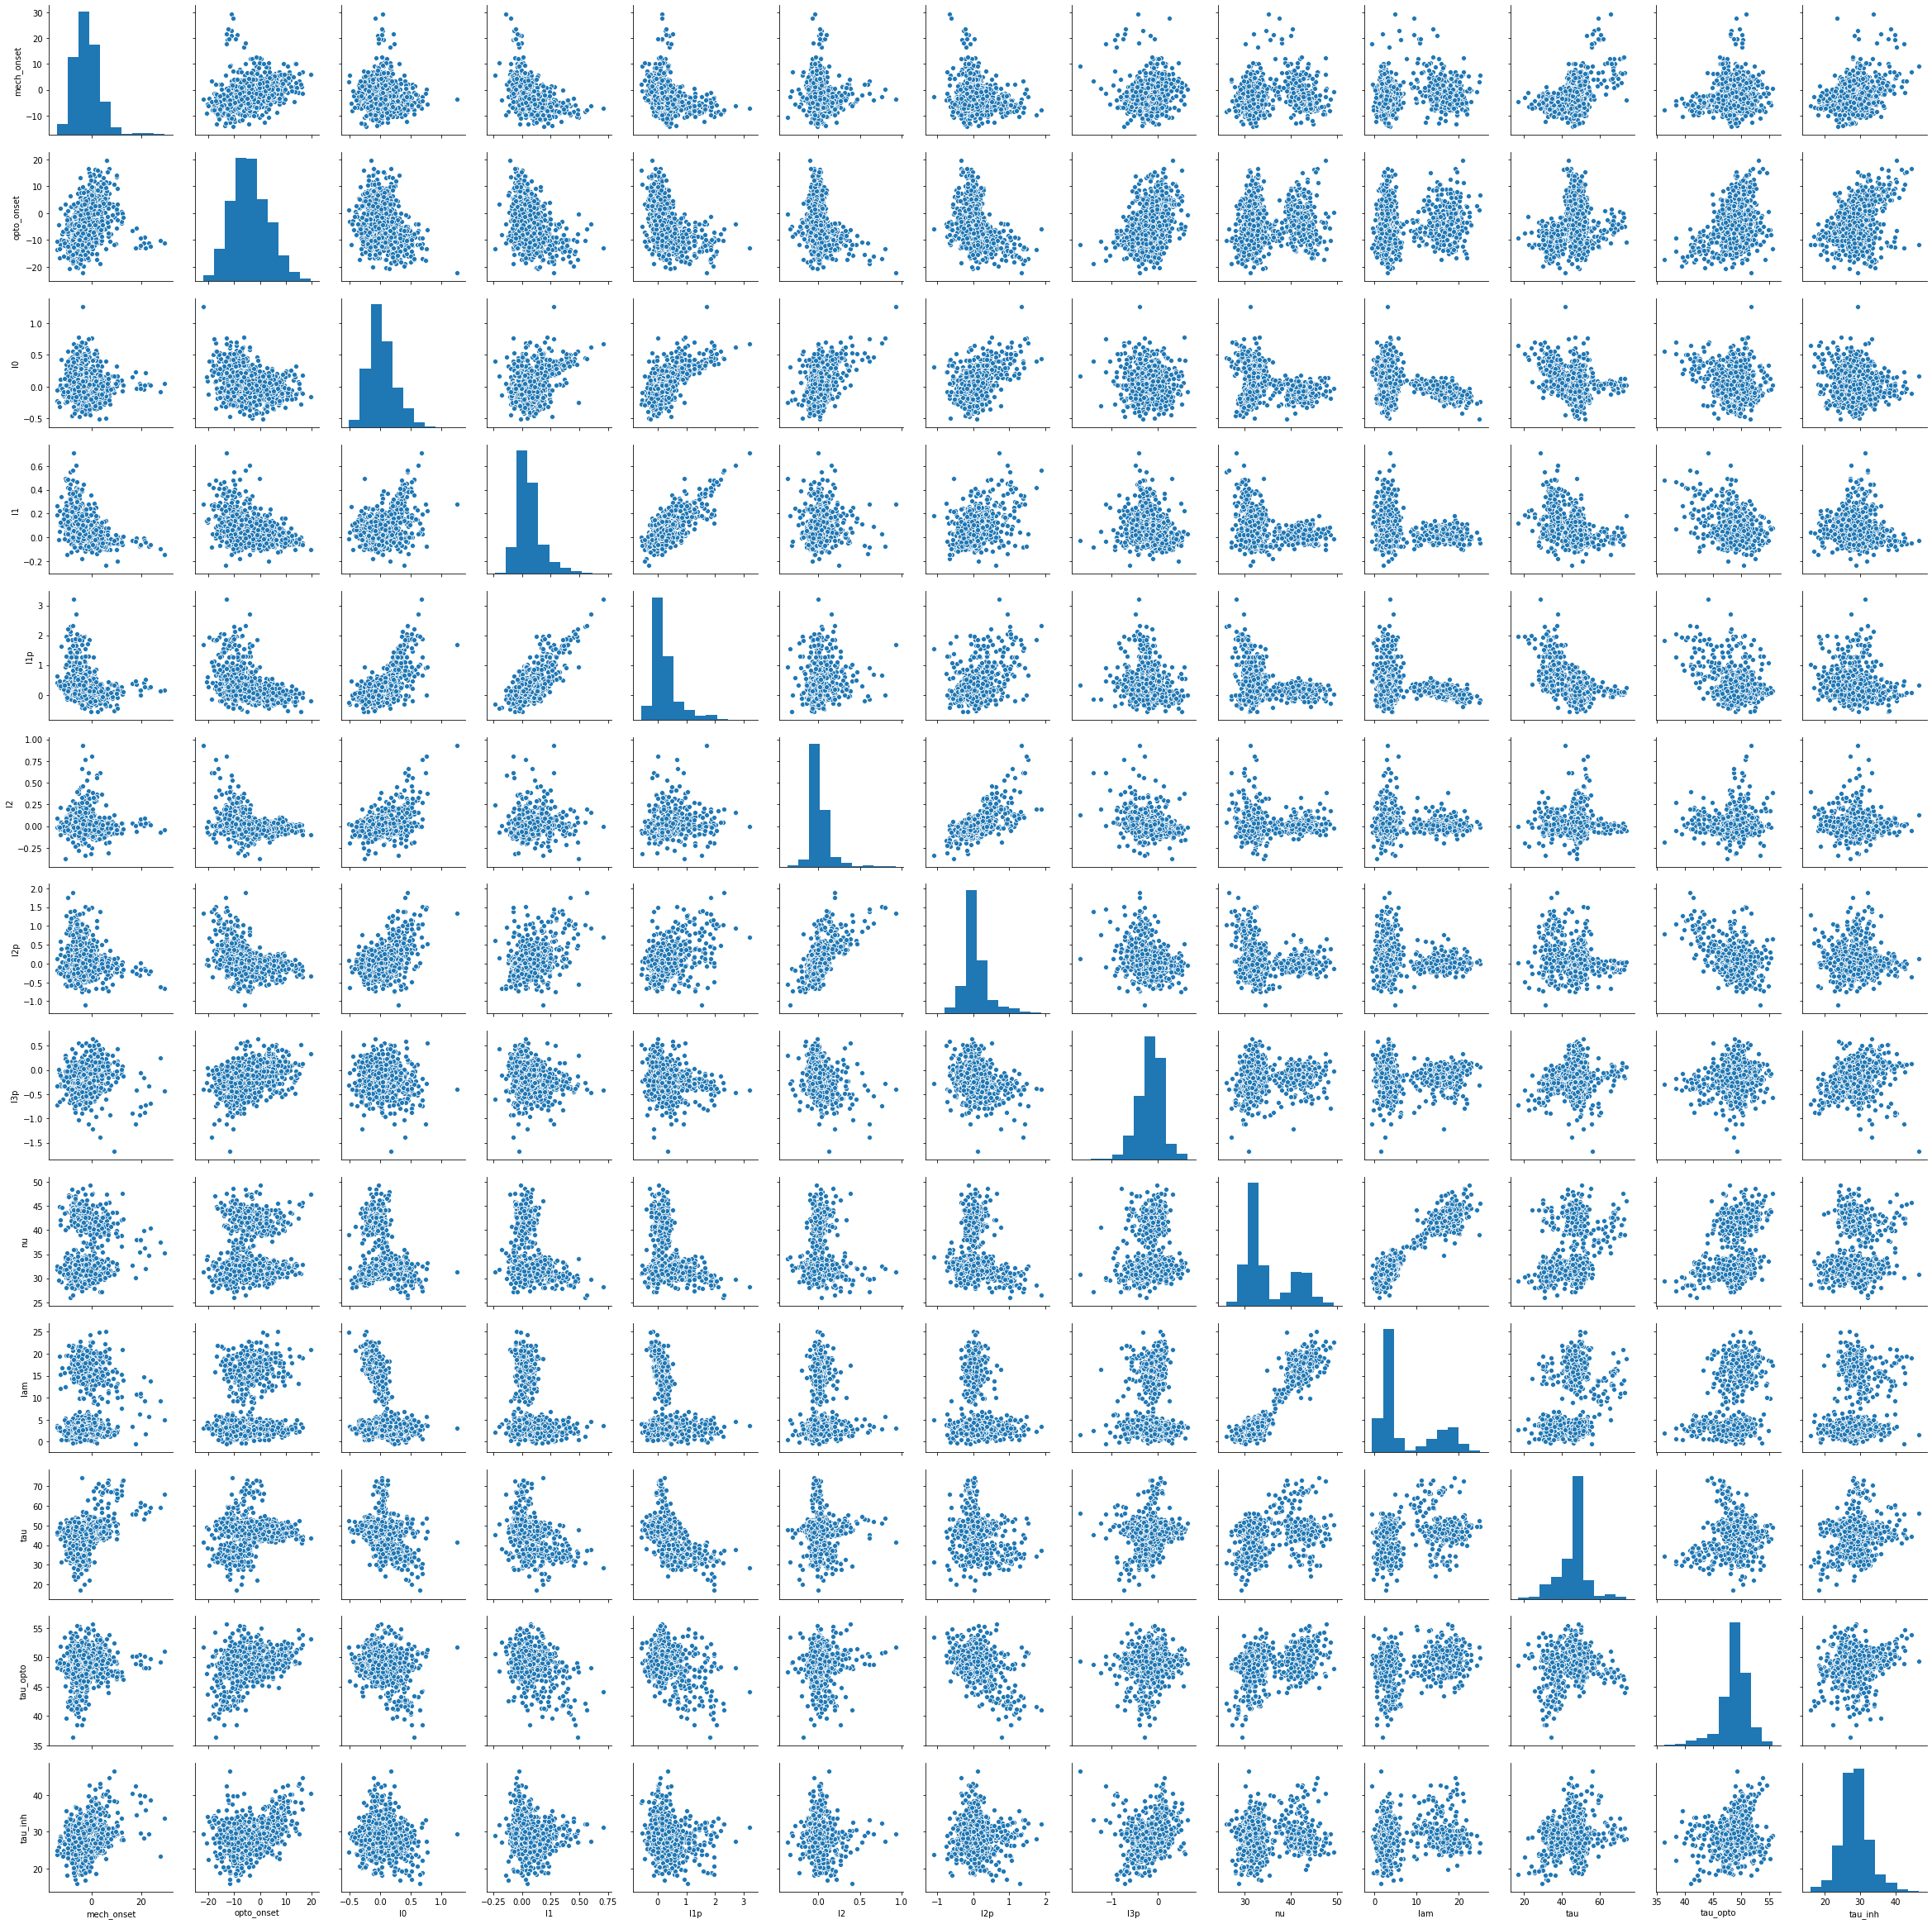

In [53]:
X, y = gmm.sample(1000)
sns.pairplot(pd.DataFrame(X, columns=train_df.columns))

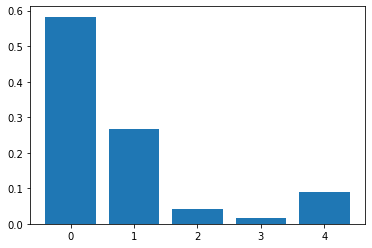

In [81]:
gmm = BayesianGaussianMixture(
    n_components=5,
    covariance_type='full',
    n_init=5,
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=1e-6,
)
train_df = df.xs("mean", axis=1, level=1).drop(
    columns=[
        "mech_onset",
        "opto_onset",
#         "I0",
#         "nu",
#         "lam",
        "tau",
        "tau_inh",
        "tau_opto",
    ]
)
label = pd.Series(data=gmm.fit_predict(train_df), index=train_df.index)
plt.bar(range(len(gmm.weights_)), gmm.weights_);

/home/lpaz/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1306: UserWarning: tight_layout : falling back to Agg renderer
  fig.tight_layout()


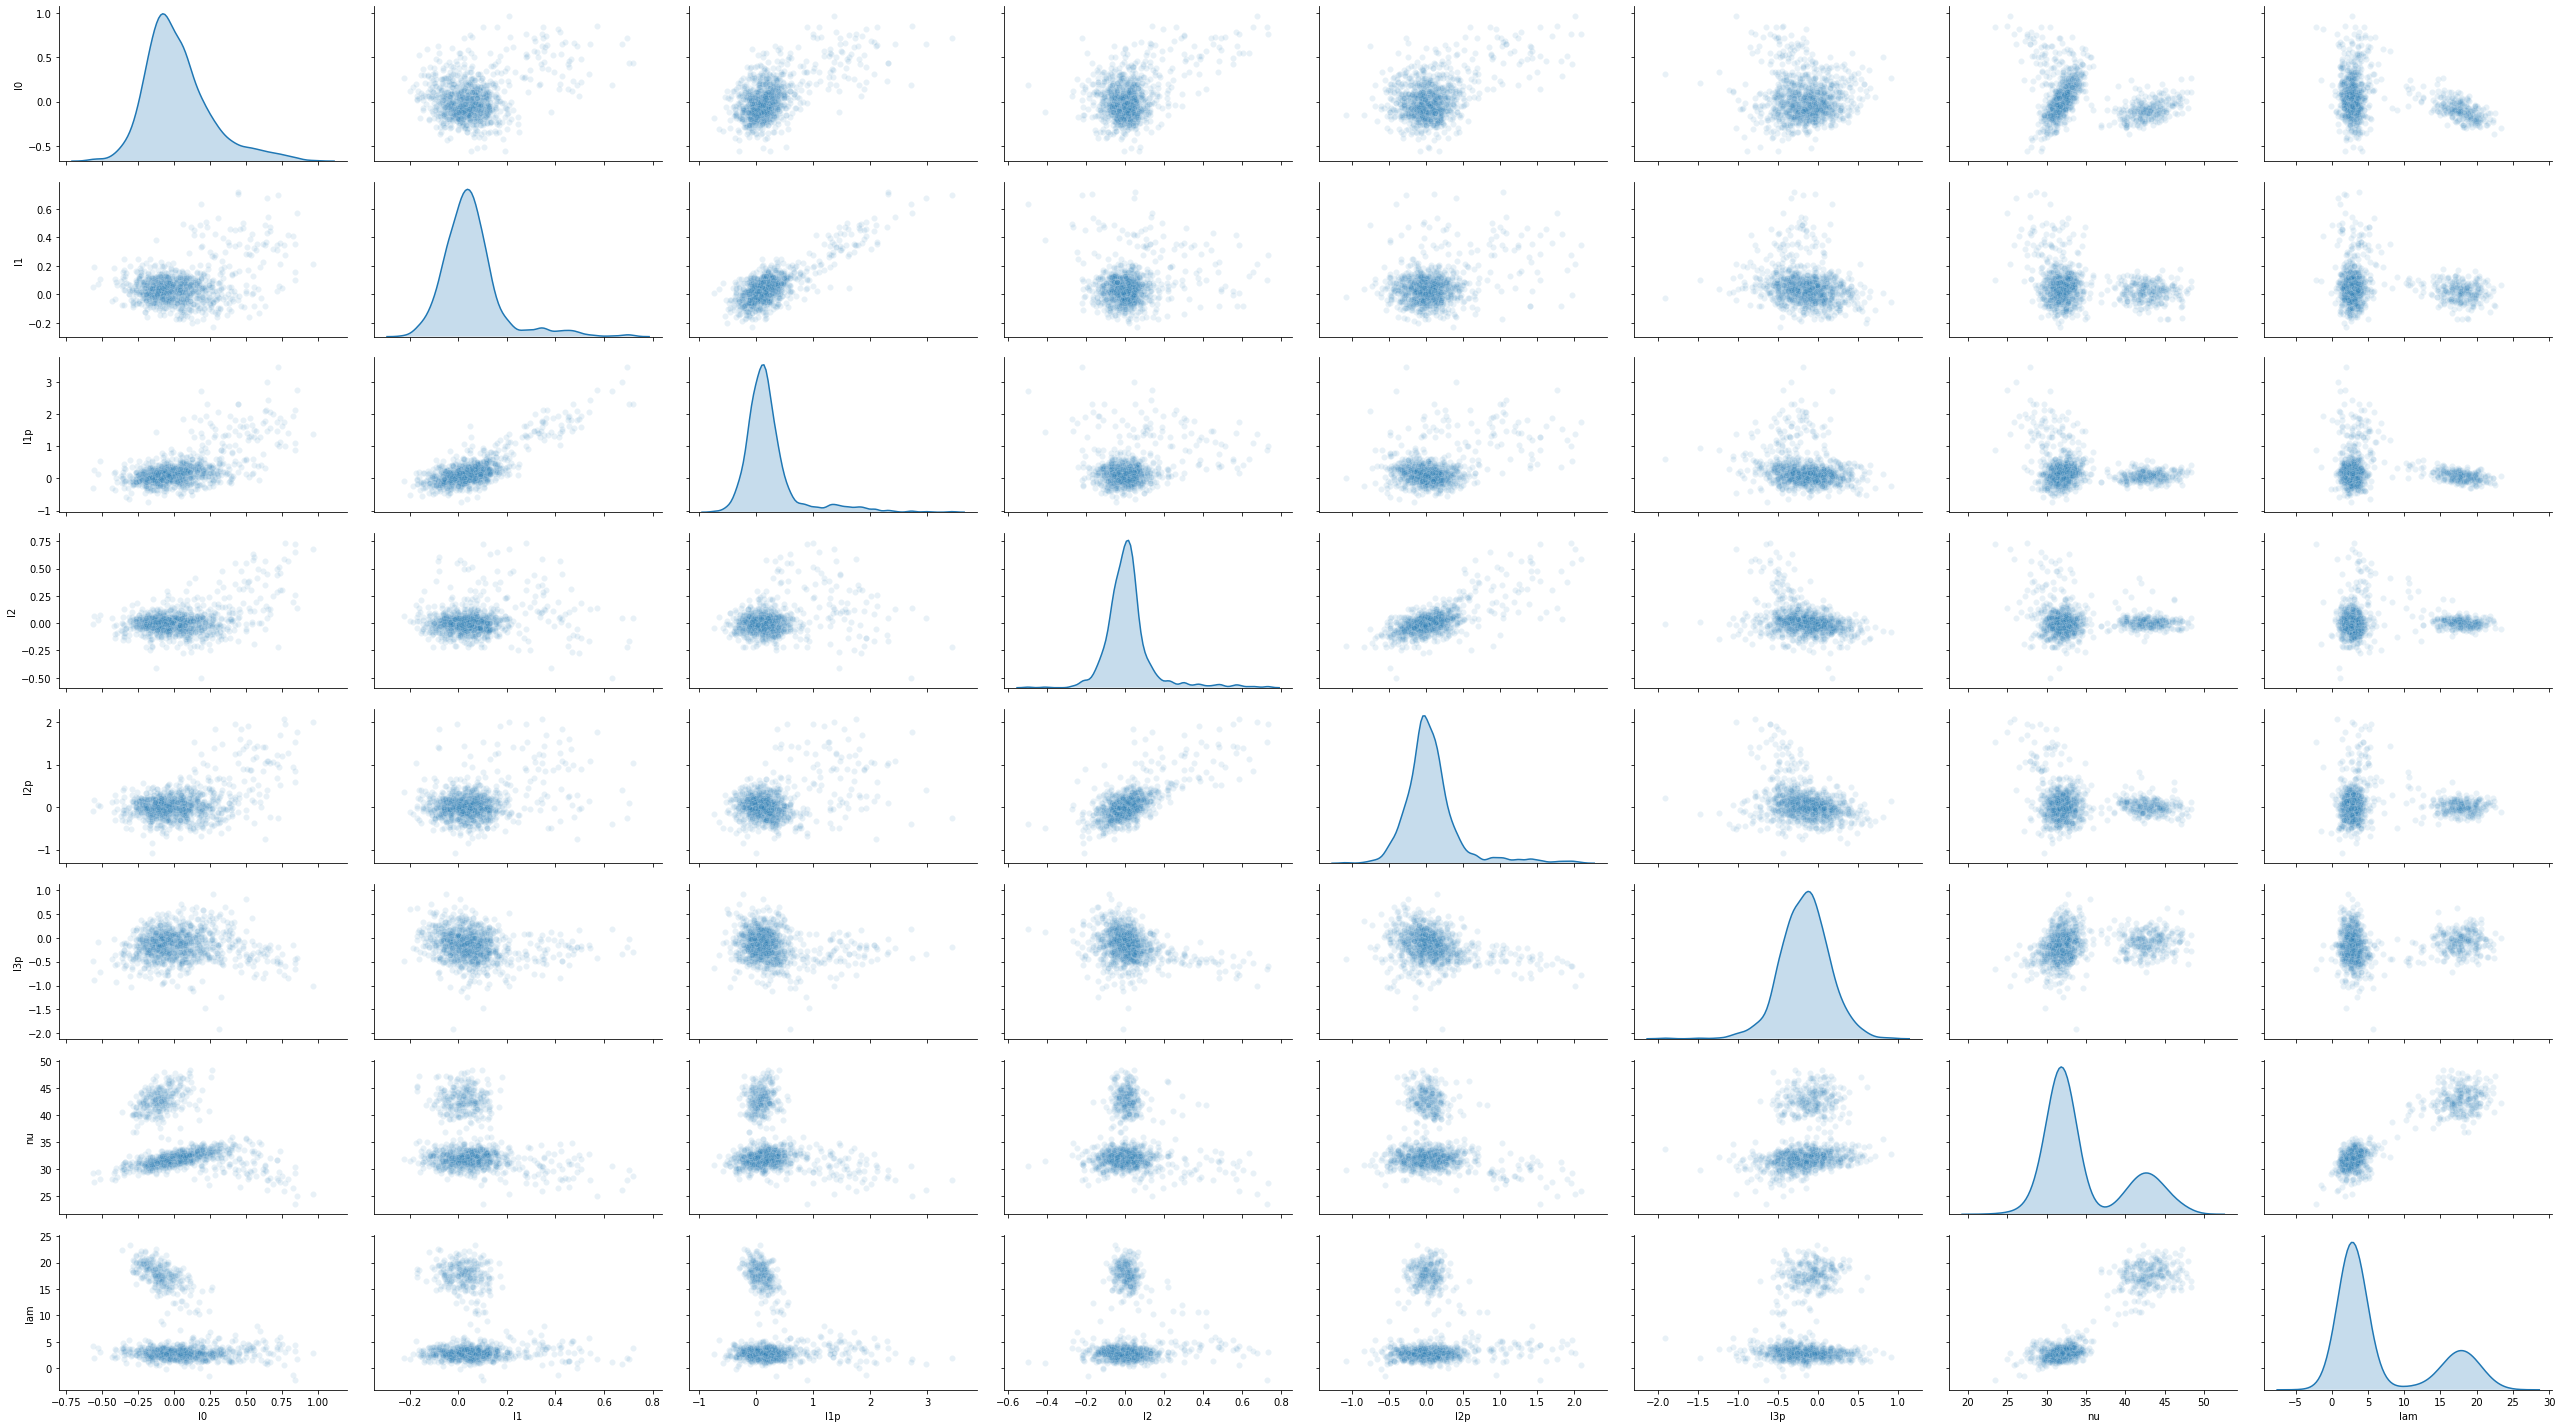

In [82]:
X, y = gmm.sample(1000)
sns.pairplot(pd.DataFrame(X, columns=train_df.columns),
             diag_kind='kde', plot_kws={"alpha": 0.1},
             aspect=16/9)

In [83]:
viz_df = train_df.assign(label=label)

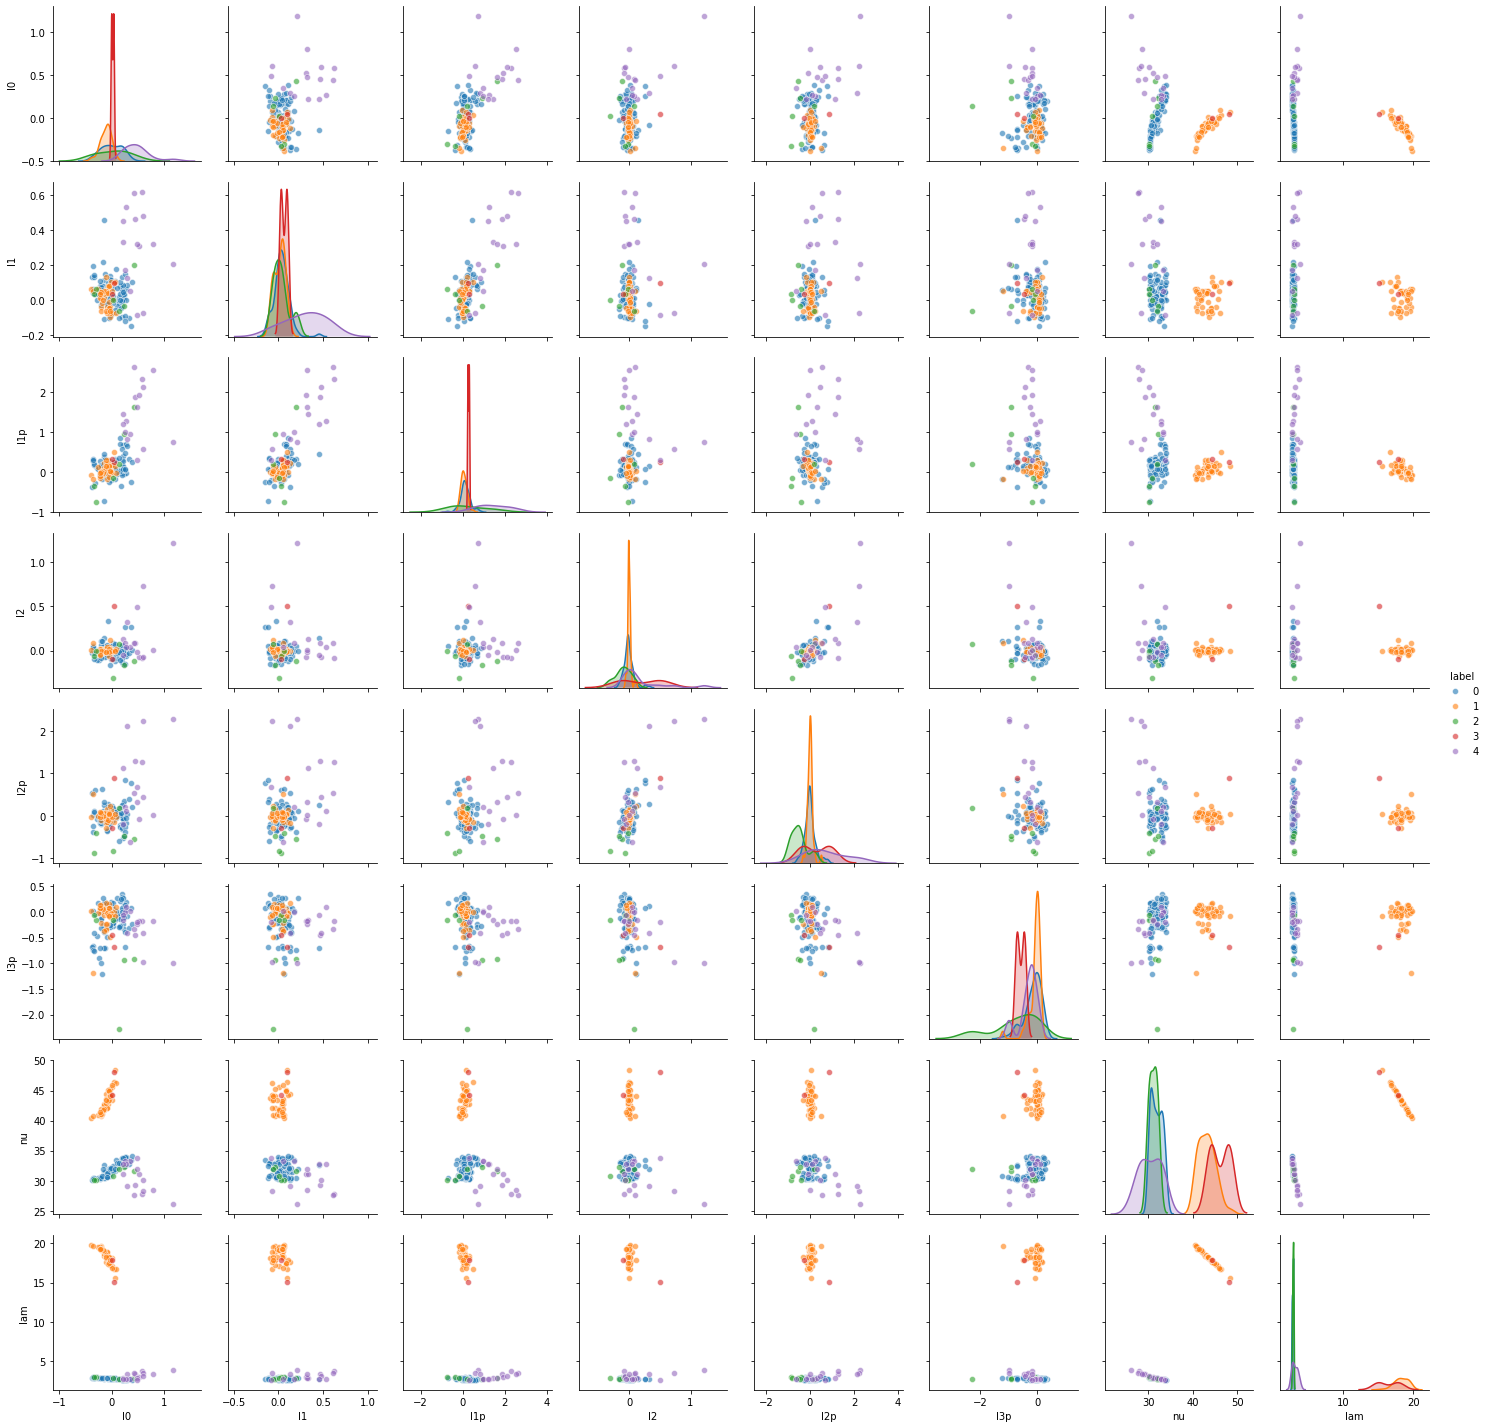

In [84]:
sns.pairplot(viz_df,
             vars=[c for c in viz_df.columns if c != "label"],
             diag_kind='kde',
             hue="label",
             plot_kws={"alpha": 0.6},)

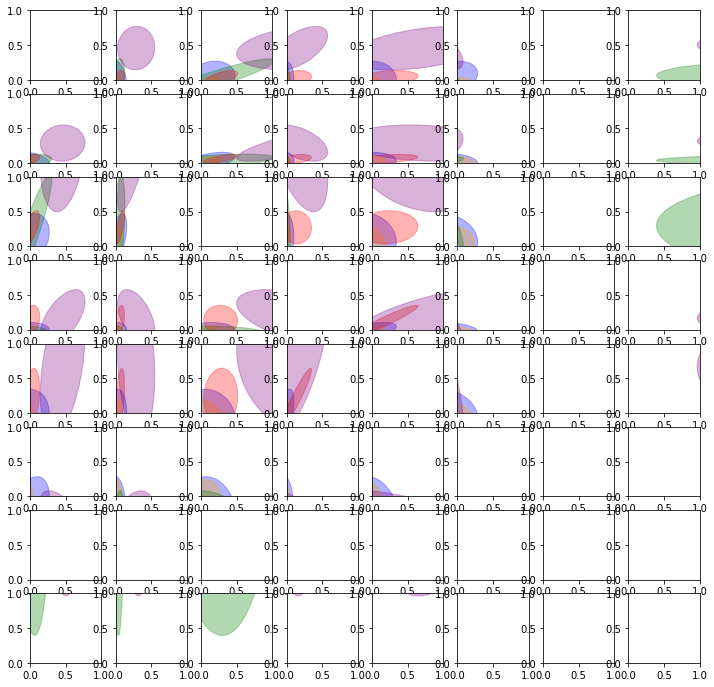

In [85]:
import matplotlib as mpl
from scipy import linalg


def plot_ellipses(means, covariances, colors, axs=None):
    if axs is None:
        fig, axs = plt.subplots(means.shape[1], means.shape[1], figsize=(12, 12))
    for mean, covar, color in zip(means, covariances, colors):
        for row in range(len(mean)):
            for col in range(len(mean)):
                if row == col:
                    continue
                ax = axs[row, col]
                m = mean[[col, row]]
                cov = covar[[[col, col], [row, row]], [[col, row], [col, row]]]
                v, w = linalg.eigh(cov)
                v = 2. * np.sqrt(2.) * np.sqrt(v)
                u = w[0] / linalg.norm(w[0])
                # as the DP will not use every component it has access to
                # unless it needs it, we shouldn't plot the redundant
                # components.

                # Plot an ellipse to show the Gaussian component
                angle = np.arctan(u[1] / u[0])
                angle = 180. * angle / np.pi  # convert to degrees
                ell = mpl.patches.Ellipse(m, v[0], v[1], 180. + angle, alpha=0.3, color=color)
                ax.add_artist(ell)
    return axs

colors = ["b", "orange", "green", "red", "purple"]
plot_ellipses(gmm.means_, gmm.covariances_, colors);

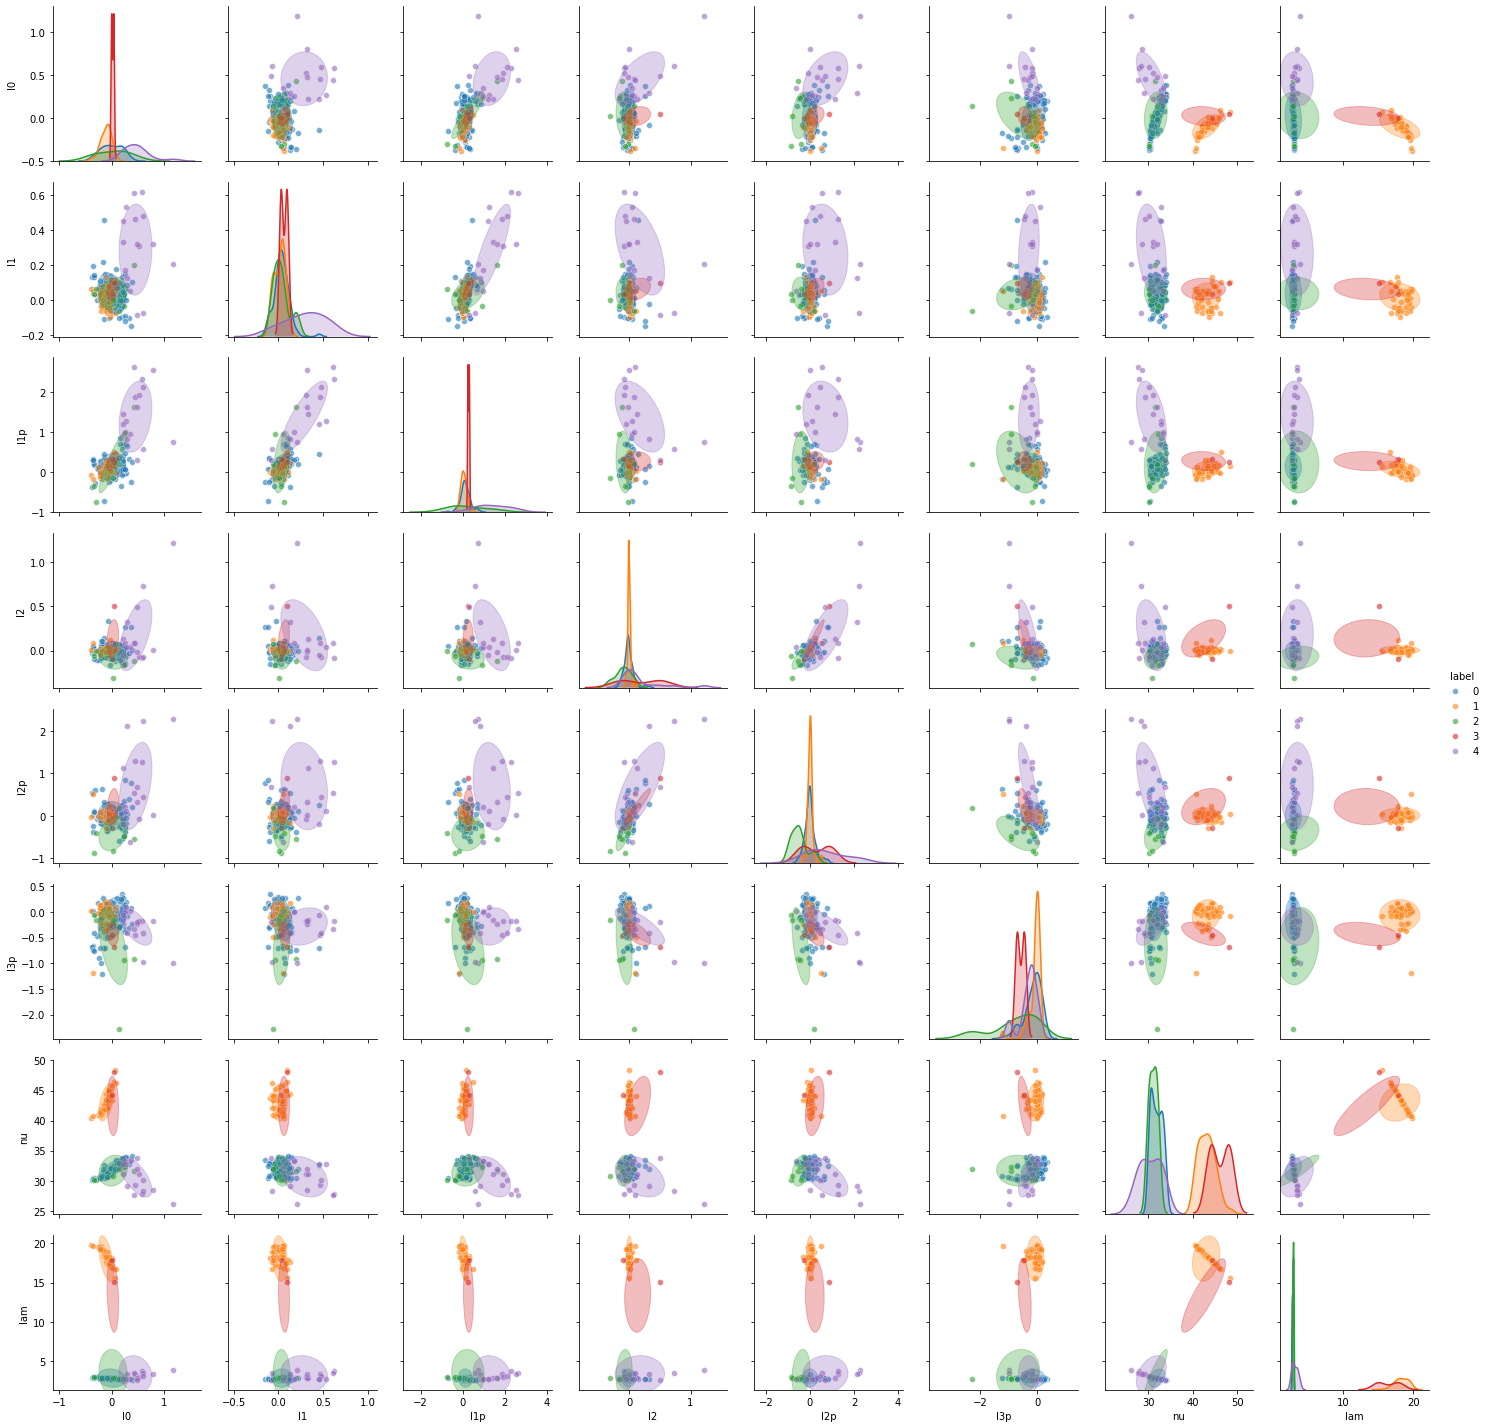

In [86]:
out = sns.pairplot(viz_df,
             vars=[c for c in viz_df.columns if c != "label"],
             diag_kind='kde',
             hue="label",
             plot_kws={"alpha": 0.6},)
colors = ["b", "orange", "green", "red", "purple"]
plot_ellipses(gmm.means_, gmm.covariances_, out.palette, axs=out.axes);

In [70]:
print(gmm.means_)

[[ 3.57236688e-03  3.88482821e-02  1.41019135e-01 -1.22602647e-02
  -3.37991140e-02 -1.62524635e-01  3.19145341e+01  2.81006147e+00]
 [-9.40132281e-02  1.57965012e-02  7.74038569e-02  4.26154231e-04
  -8.16865564e-03 -5.16268075e-02  4.30873770e+01  1.80355491e+01]
 [ 4.58397844e-01  2.78132900e-01  1.37057008e+00  1.72218788e-01
   7.17134637e-01 -3.69354966e-01  3.05998466e+01  3.31938555e+00]
 [-1.60883637e-01  5.64478121e-02  4.26117808e-02  5.24750904e-02
   2.92371010e-01 -6.81772967e-01  3.78338752e+01  1.33869056e+01]
 [ 3.39401119e-02  7.80994546e-02  2.55468061e-01  2.57507734e-01
   4.72010662e-01 -4.26682721e-01  4.15317496e+01  1.11103853e+01]]


In [68]:
out.palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

In [58]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

#### Cluster 0

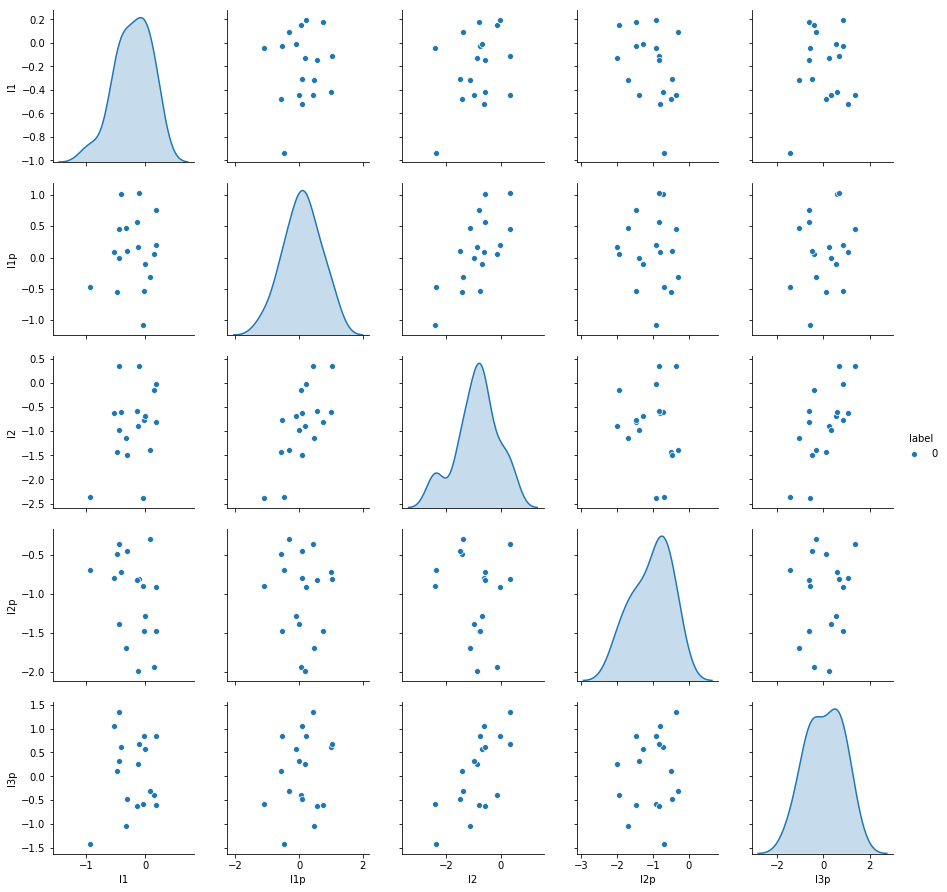

In [470]:
queried_label = 0
sns.pairplot(data=viz_df.query("label==@queried_label"),
             vars=[c for c in viz_df.columns if c != "label"],
             diag_kind='kde',
             hue="label",
             palette={queried_label: sns.color_palette()[queried_label]})

#### Cluster 1

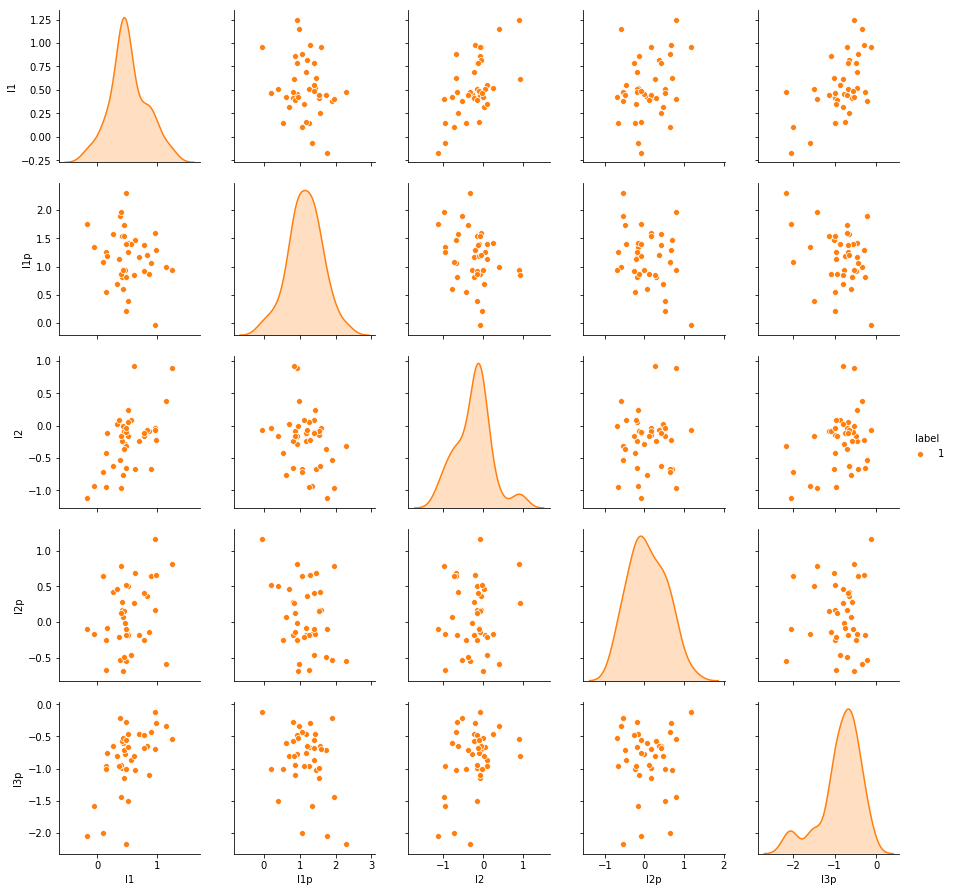

In [471]:
queried_label = 1
sns.pairplot(data=viz_df.query("label==@queried_label"),
             vars=[c for c in viz_df.columns if c != "label"],
             diag_kind='kde',
             hue="label",
             palette={queried_label: sns.color_palette()[queried_label]})

#### Cluster 2

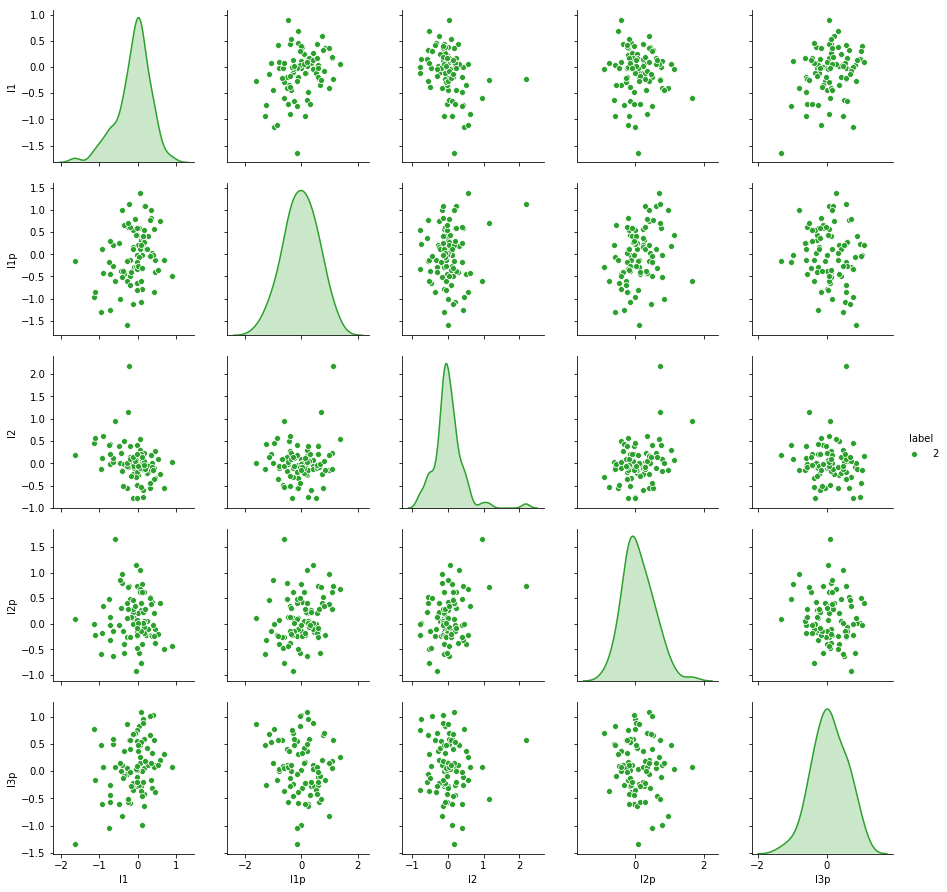

In [472]:
queried_label = 2
sns.pairplot(data=viz_df.query("label==@queried_label"),
             vars=[c for c in viz_df.columns if c != "label"],
             diag_kind='kde',
             hue="label",
             palette={queried_label: sns.color_palette()[queried_label]})

#### Cluster 3

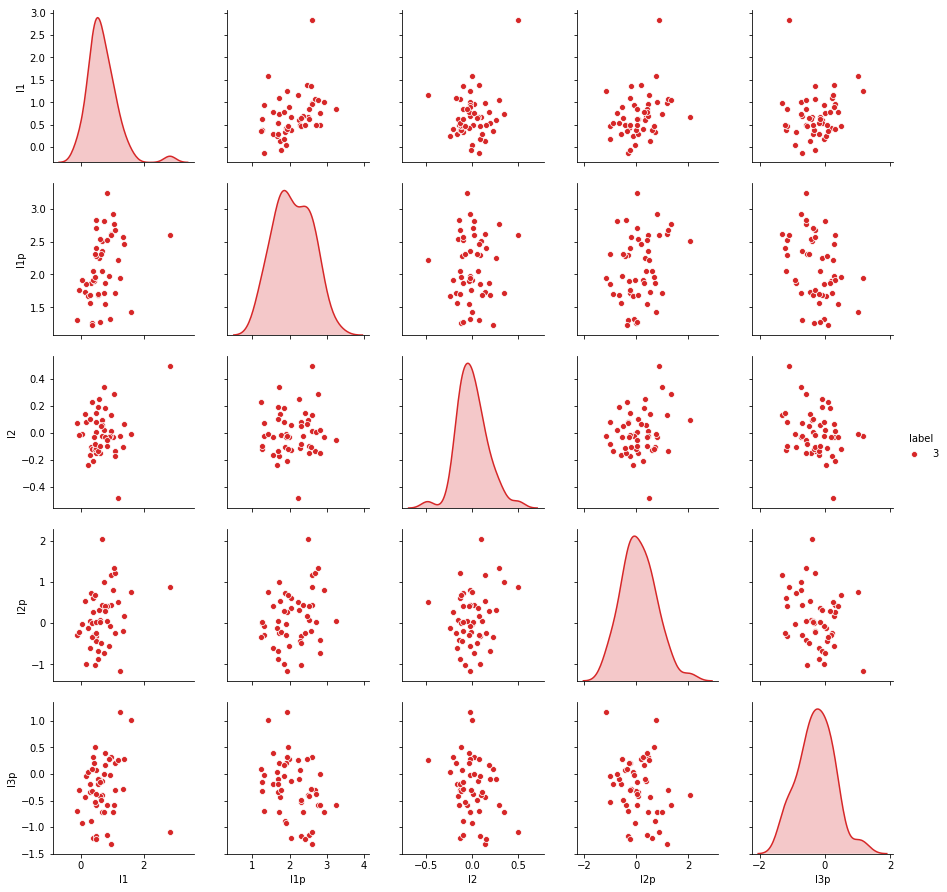

In [473]:
queried_label = 3
sns.pairplot(data=viz_df.query("label==@queried_label"),
             vars=[c for c in viz_df.columns if c != "label"],
             diag_kind='kde',
             hue="label",
             palette={queried_label: sns.color_palette()[queried_label]})

In [474]:
hand_label = np.dot(pie_df.values, np.arange(4))
viz_df2 = viz_df.assign(label=pie_df.columns[hand_label])
viz_df2

ValueError: Length of values does not match length of index

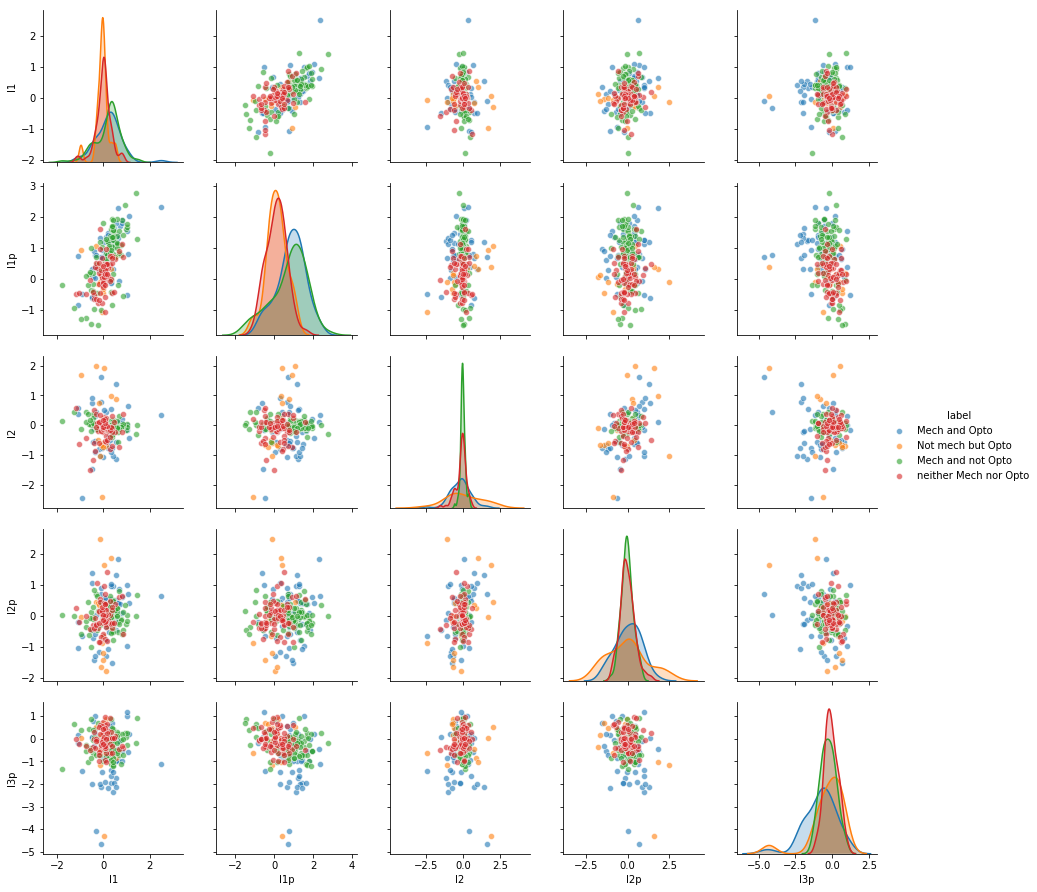

In [475]:
sns.pairplot(viz_df2,
             vars=[c for c in viz_df2.columns if c != "label"],
             diag_kind='kde',
             hue="label",
             plot_kws={"alpha": 0.6},)

In [33]:
from scipy.special import expit, logit

def _tuning_curve(lam, I0, I):
    return lam * expit(I0 + I) + 1e-3


def tuning_curve(nu, lam, I0, I):
    return lam * (1 - (1 / (1 + np.exp((I + I0))) ** (1/nu)))

In [16]:
df.xs('mean', axis=1, level=1)[viz_df.label!=0]

mech_onset  opto_onset        I0        I1       I1p        I2       I2p  \
nid                                                                             
2     -4.872916  -24.440595  0.073049  0.111135  0.334665 -0.115774  0.138777   
10    -6.239167  -11.870000 -0.149256  0.117228  0.381379  0.001198  0.066496   
13    -1.037710  -11.406771  0.007641  0.011715  0.003160  0.041327  0.225521   
14    -4.708451   -8.544419  0.211091  0.080787  0.687821 -0.026423  0.283222   
15    -5.888488  -13.225616 -0.346319  0.042522  0.283189  0.019389  0.017088   
18    -0.816667    1.397418  0.147304  0.015687  0.077780  0.002284  0.069445   
20     4.669905   -9.903161  0.241469  0.029666 -0.060113  0.020308  0.346792   
21     0.465360    0.095070  0.231972  0.007167  0.062158 -0.058567  0.061270   
22    -4.132444   -8.849250  0.351684  0.054423  0.949848  0.043151 -0.622436   
23     0.882406    0.516580 -0.033032 -0.002445  0.095705 -0.008309 -0.065237   
25     0.676357    2.719066  0.190676 -0.033962 -0.026378 -0.008123  0.041215   
26     0.149707   -4.696847 -0.129217  0.001363  0.326567  0.013210 -0.104384   
27     0.639128   -3.195596  0.208966  0.043298  0.305240  0.054128  0.255201   
28    -1.888915   -4.503664 -0.076394 -0.025115  0.150156  0.331953  0.289219   
30    -4.110811    2.882160 -0.233014  0.064433  0.117045 -0.102817 -0.033606   
31    -3.311646   -5.502751 -0.375593  0.130858 -0.385778 -0.030418  0.540347   
33    -4.578902   -7.726412  0.278528  0.065566  0.698657 -0.058179 -0.156362   
35    -3.733335   -2.400866  0.194720  0.059211  0.140697 -0.012985 -0.051536   
36    -0.660783   -2.005806 -0.305357  0.061402 -0.752568 -0.009748 -0.401420   
37    -0.408763   -4.254524  0.067071  0.001516 -0.176263 -0.012790  0.089011   
40   -12.566401    0.154391 -0.359324  0.193323  0.336867  0.056003 -0.377725   
42    -4.346653  -14.585794  0.254144  0.170455  0.992882  0.087001  0.220640   
43     0.649105   -8.018821  0.373864 -0.148535 -0.247539  0.267232  0.763455   
45    -5.158639   -4.813435 -0.127777  0.149494  0.337062 -0.064815  0.071476   
47    -5.549844    0.916867  0.227183  0.005926  0.161801  0.050266 -0.038949   
49     0.836836    0.183959  0.147938 -0.018629  0.034526 -0.037961  0.037410   
50     1.361501   -0.452032  0.010296  0.037666  0.020490 -0.029144  0.013492   
51    -9.866885   -7.470141  0.161659  0.082370  0.694925 -0.028514  0.197384   
54    -0.999471    0.013197  0.069181 -0.070000  0.045020  0.057339 -0.010063   
56    -9.737328  -12.368630  0.296364  0.084109  0.647296  0.029711  0.040425   
..          ...         ...       ...       ...       ...       ...       ...   
192   -4.172079   16.274813  0.213216  0.044968  0.082253 -0.004629 -0.219572   
195   10.064849   11.798904  0.175567 -0.044420 -0.338748 -0.000928  0.071238   
197   -9.735883  -11.866183 -0.023996  0.120255  0.146651 -0.011433 -0.042250   
198  -10.379472  -12.070393 -0.005595  0.113929  0.171359 -0.023482 -0.075052   
200   -6.494854  -13.710357 -0.009029  0.103841 -0.009465 -0.008853  0.142846   
201    9.646844    5.212217 -0.174913 -0.019359 -0.083776  0.009510 -0.015751   
202    1.505366   10.741175 -0.226220  0.011642 -0.147611  0.018417  0.018272   
203   -9.614713  -11.771452 -0.102992  0.038091  0.090727 -0.014528  0.002894   
205   -6.017247    0.045270 -0.142969  0.050175  0.034567 -0.016421  0.060936   
206   -4.285695   -1.058762 -0.066093  0.041990  0.104750  0.000855 -0.084346   
207   -0.738584    9.648459 -0.156268  0.002289 -0.030067 -0.006012  0.004751   
208   -5.898399   -7.414560  0.002339  0.052339  0.170540 -0.009867 -0.024451   
209  -11.733790  -12.066420  0.072751  0.101769  0.154411 -0.008423  0.048681   
210    7.465240    7.236593 -0.055774 -0.011938 -0.134819  0.013277  0.066978   
211  -11.870893   -6.672453 -0.042570  0.081690  0.153323 -0.012460  0.041866   
212  -11.475314  -15.121100 -0.251563  0.062798  0.134961 -0.009091 -0.008644   
213    3.623917   -0.615738 -0.38377

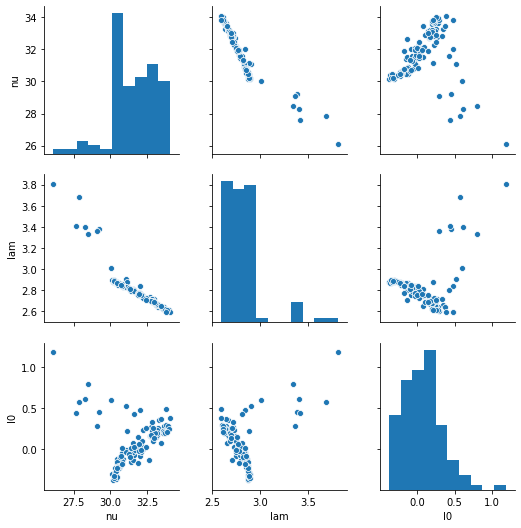

In [18]:
temp_df = df.xs('mean', axis=1, level=1)[['nu', 'lam', 'I0']]
temp_df = temp_df[temp_df.nu < 40]
nu, lam, I0 = temp_df.values.T
sns.pairplot(temp_df)

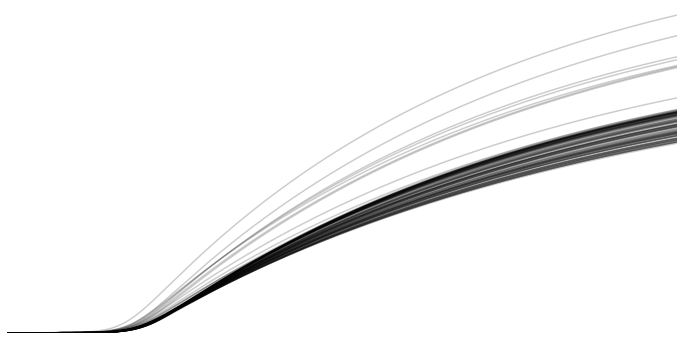

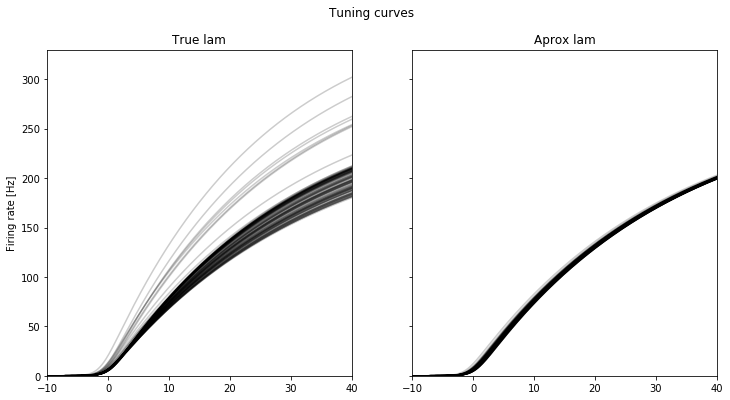

In [29]:
I = np.linspace(- 10, 40, 1000)
I2 = I
f = tuning_curve(nu[..., None], lam[..., None], I0[..., None], I2)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(I, f.T * 100, 'k', alpha=0.2)
ax.autoscale(axis='x', tight=True)
ax.set_ylabel('Firing rate [Hz]')
ax.set_xlabel('Input current above baseline')
ax.set_ylim([0, 310])
ax.axis("off")


fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axs[0].plot(I, f.T * 100, 'k', alpha=0.2)
axs[0].autoscale(axis='x', tight=True)
axs[0].set_title('True lam')
axs[0].set_ylabel('Firing rate [Hz]')
axs[0].set_ylim([0, 330])
axs[1].plot(I, tuning_curve(np.median(nu), np.median(lam), I0[..., None], I2).T * 100, 'k', alpha=0.2)
axs[1].autoscale(axis='x', tight=True)
axs[1].set_title('Aprox lam')
fig.suptitle('Tuning curves');

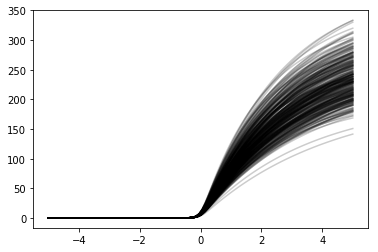

In [21]:
from simple_model import tuning_curve_model

I = np.linspace(-5, 5, 100)
with tuning_curve_model(I, nu_mu=30, nu_sigma=5, lam_mu=2.9, lam_sigma=0.4):
    prior = pm.sample_prior_predictive(300)

plt.plot(I, prior["F"].T, "k", alpha=0.2);

In [42]:
def response_rate(t,
                  T,
                  mech=True,
                  light=False,
                  onset=0.,
                  lam=26.,
                  I0=0.,
                  I1=0.,
                  I1p=0.,
                  I2=0.,
                  I2p=0.,
                  I3p=0.,
                  tau=0.,
                  tau_opto=0.,
                  tau_inh=0.,
                 ):
    offset_t = t - T
    w = (
        expit(1 * (t - onset))
        * expit(-1 * (offset_t - onset))
        )
    if light:
        w2 = expit(1 * (offset_t - onset))
    else:
        w2 = 0.
    if mech and light:
        input_current = I0 + (
            w * (
                I1
                + (I1p - I1)
                * np.exp(-(t - onset) / tau)
                + I2
                + (I2p - I2)
                * np.exp(-(t - onset) / tau_opto)
            )
            + w2
            * I3p *
            np.exp(-(offset_t - onset) / tau_inh)
        )
    elif mech:
        input_current = I0 + (
            w * (
                I1
                + (I1p - I1)
                * np.exp(-(t - onset) / tau)
            )
        )
    elif light:
        input_current = I0 + (
            w * (
                I2
                + (I2p - I2)
                * np.exp(-(t - onset) / tau_opto)
            )
            + w2
            * I3p *
            np.exp(-(offset_t - onset) / tau_inh)
        )
    else:
        I0, t = np.broadcast_arrays(I0, t)
        input_current = I0
    return expit(input_current) * lam + 1e-3

In [299]:
T = np.sort(stacked_df.T2.unique())[:, None, None]
t = np.linspace(0, 694, 695)[:, None]

In [300]:
temp_df = df.xs('mean', axis=1, level=1)

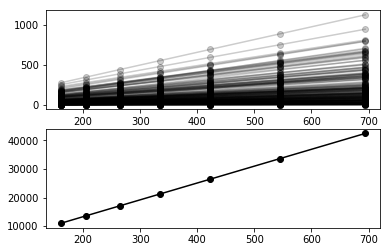

In [301]:
o = response_rate(
    t,
    T,
    mech=True,
    light=False,
    onset=0.,
    lam=temp_df.lam.values.flatten(),
    I0=temp_df.I0.values.flatten(),
    I1=temp_df.I1.values.flatten(),
    I1p=temp_df.I1p.values.flatten(),
    I2=temp_df.I2.values.flatten(),
    I2p=temp_df.I2p.values.flatten(),
    I3p=temp_df.I3p.values.flatten(),
    tau=temp_df.tau.values.flatten(),
    tau_opto=temp_df.tau_opto.values.flatten(),
    tau_inh=temp_df.tau_inh.values.flatten(),
)
o2 = np.cumsum(o, axis=1)
o2 = np.array([o2[i, int(TT)] for i, TT in enumerate(T)])

plt.subplot(2, 1, 1)
plt.plot(np.squeeze(T), o2, '-ok', alpha=0.2)
plt.subplot(212)
plt.plot(np.squeeze(T), np.sum(o2, axis=1), '-ok')


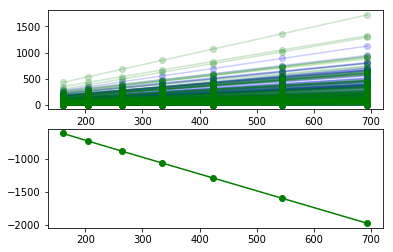

In [302]:
o1 = response_rate(
    t,
    T,
    mech=True,
    light=False,
    onset=0.,
    lam=temp_df.lam.values.flatten(),
    I0=temp_df.I0.values.flatten(),
    I1=temp_df.I1.values.flatten(),
    I1p=temp_df.I1p.values.flatten(),
    I2=temp_df.I2.values.flatten(),
    I2p=temp_df.I2p.values.flatten(),
    I3p=temp_df.I3p.values.flatten(),
    tau=temp_df.tau.values.flatten(),
    tau_opto=temp_df.tau_opto.values.flatten(),
    tau_inh=temp_df.tau_inh.values.flatten(),
)
o2 = response_rate(
    t,
    T,
    mech=True,
    light=True,
    onset=0.,
    lam=temp_df.lam.values.flatten(),
    I0=temp_df.I0.values.flatten(),
    I1=temp_df.I1.values.flatten(),
    I1p=temp_df.I1p.values.flatten(),
    I2=temp_df.I2.values.flatten(),
    I2p=temp_df.I2p.values.flatten(),
    I3p=temp_df.I3p.values.flatten(),
    tau=temp_df.tau.values.flatten(),
    tau_opto=temp_df.tau_opto.values.flatten(),
    tau_inh=temp_df.tau_inh.values.flatten(),
)
temp = np.cumsum(o1, axis=1)
o1 = np.array([temp[i, int(TT)] for i, TT in enumerate(T)])
temp = np.cumsum(o2, axis=1)
o2 = np.array([temp[i, int(TT)] for i, TT in enumerate(T)])

plt.subplot(2, 1, 1)
plt.plot(np.squeeze(T), o1, '-ob', alpha=0.2)
plt.plot(np.squeeze(T), o2, '-og', alpha=0.2)
plt.subplot(212)
plt.plot(np.squeeze(T), np.sum(o1, axis=1) - np.sum(o2, axis=1), '-og')


(array([173]),)
(7, 228) (228,)


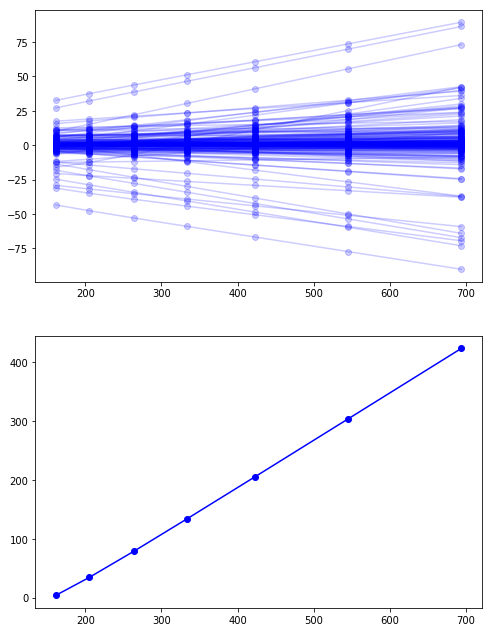

In [303]:
o1 = (response_rate(
    t,
    T,
    mech=True,
    light=False,
    onset=0.,
    lam=temp_df.lam.values.flatten(),
    I0=temp_df.I0.values.flatten(),
    I1=temp_df.I1.values.flatten(),
    I1p=temp_df.I1p.values.flatten(),
    I2=temp_df.I2.values.flatten(),
    I2p=temp_df.I2p.values.flatten(),
    I3p=temp_df.I3p.values.flatten(),
    tau=temp_df.tau.values.flatten(),
    tau_opto=temp_df.tau_opto.values.flatten(),
    tau_inh=temp_df.tau_inh.values.flatten(),
) + response_rate(
    t,
    T,
    mech=False,
    light=True,
    onset=0.,
    lam=temp_df.lam.values.flatten(),
    I0=temp_df.I0.values.flatten(),
    I1=temp_df.I1.values.flatten(),
    I1p=temp_df.I1p.values.flatten(),
    I2=temp_df.I2.values.flatten(),
    I2p=temp_df.I2p.values.flatten(),
    I3p=temp_df.I3p.values.flatten(),
    tau=temp_df.tau.values.flatten(),
    tau_opto=temp_df.tau_opto.values.flatten(),
    tau_inh=temp_df.tau_inh.values.flatten(),
))
o2 = (response_rate(
    t,
    T,
    mech=True,
    light=True,
    onset=0.,
    lam=temp_df.lam.values.flatten(),
    I0=temp_df.I0.values.flatten(),
    I1=temp_df.I1.values.flatten(),
    I1p=temp_df.I1p.values.flatten(),
    I2=temp_df.I2.values.flatten(),
    I2p=temp_df.I2p.values.flatten(),
    I3p=temp_df.I3p.values.flatten(),
    tau=temp_df.tau.values.flatten(),
    tau_opto=temp_df.tau_opto.values.flatten(),
    tau_inh=temp_df.tau_inh.values.flatten(),
) + response_rate(
    t,
    T,
    mech=False,
    light=False,
    onset=0.,
    lam=temp_df.lam.values.flatten(),
    I0=temp_df.I0.values.flatten(),
    I1=temp_df.I1.values.flatten(),
    I1p=temp_df.I1p.values.flatten(),
    I2=temp_df.I2.values.flatten(),
    I2p=temp_df.I2p.values.flatten(),
    I3p=temp_df.I3p.values.flatten(),
    tau=temp_df.tau.values.flatten(),
    tau_opto=temp_df.tau_opto.values.flatten(),
    tau_inh=temp_df.tau_inh.values.flatten(),
))
temp = np.cumsum(o1, axis=1)
o1 = np.array([temp[i, int(TT)] for i, TT in enumerate(T)])
temp = np.cumsum(o2, axis=1)
o2 = np.array([temp[i, int(TT)] for i, TT in enumerate(T)])

outlier = np.all(o1 - o2 < -100, axis=0)
print(np.where(outlier))
print(o1.shape, outlier.shape)

fig, axs = plt.subplots(2, 1, figsize=(8, 11))
axs[0].plot(np.squeeze(T), (o1 - o2)[:, np.logical_not(outlier)], '-ob', alpha=0.2)
axs[1].plot(np.squeeze(T), np.sum(o1[:, np.logical_not(outlier)], axis=1) - np.sum(o2[:, np.logical_not(outlier)], axis=1), '-ob')
# axs[1].plot(np.squeeze(T), np.sum(o2, axis=1), '-og')


In [521]:
convolve = np.vectorize(np.convolve, signature="(i),(j)->(k)")
from scipy.special import erf

class _population():
    def __init__(
        self,
        parameters_df,
        n_components=5,
        gmm_on_parameters=None,
    ):
        gmm = BayesianGaussianMixture(
            n_components=n_components,
            covariance_type='full',
            n_init=10,
            weight_concentration_prior_type='dirichlet_process',
            weight_concentration_prior=1e-6
        )
        self.parameters = parameters_df.xs(
            "mean",
            axis=1,
            level=1,
        )
        self.set_gmm_parameters(gmm_on_parameters)
        self.gmm = gmm.fit(self.gmm_parameters)

    def set_gmm_parameters(self, gmm_on_parameters=None):
        if gmm_on_parameters is None:
            gmm_on_parameters = [
                "I1",
                "I1p",
                "I2",
                "I2p",
                "I3p",
            ]
        self.gmm_parameters = self.parameters[gmm_on_parameters]
        self.gmm_columns = gmm_on_parameters
        self.median_columns = [c for c in self.parameters if c not in gmm_on_parameters]
        self.medians = self.parameters[self.median_columns].median(axis=0)

    def sample(self, n_samples=1):
        samples, label = self.gmm.sample(n_samples)
        output = pd.DataFrame(data=samples, columns=self.gmm_columns)
        output = output.assign(
            **{k: v * np.ones(n_samples)
               for k, v in self.medians.items()}
        )
        return output.assign(label=label)

    def response_rate(
        self,
        t,
        T,
        mech=True,
        light=False,
        samples=None,
        reduce=True,
    ):
        if samples is None:
            samples = self.sample()[0]
        onset = 0.
#         if light:
#             onset = samples['opto_onset'].values
#         else:
#             onset = samples['mech_onset'].values
        lam = samples['lam'].values
        I0 = samples['I0'].values
        I1 = samples['I1'].values
        I1p = samples['I1p'].values
        I2 = samples['I2'].values
        I2p = samples['I2p'].values
        I3p = samples['I3p'].values
        tau = samples['tau'].values
        tau_opto = samples['tau_opto'].values
        tau_inh = samples['tau_inh'].values

        offset_t = t - T
        w = (
            expit(1 * (t - onset))
            * expit(-1 * (offset_t - onset))
            )
        if light:
            w2 = expit(1 * (offset_t - onset))
        else:
            w2 = 0.
        if mech and light:
            input_current = I0 + (
                w * (
                    I1
                    + (I1p - I1)
                    * np.exp(-(t - onset) / tau)
                    + I2
                    + (I2p - I2)
                    * np.exp(-(t - onset) / tau_opto)
                )
                + w2
                * I3p *
                np.exp(-(offset_t - onset) / tau_inh)
            )
        elif mech:
            input_current = I0 + (
                w * (
                    I1
                    + (I1p - I1)
                    * np.exp(-(t - onset) / tau)
                )
            )
        elif light:
            input_current = I0 + (
                w * (
                    I2
                    + (I2p - I2)
                    * np.exp(-(t - onset) / tau_opto)
                )
                + w2
                * I3p *
                np.exp(-(offset_t - onset) / tau_inh)
            )
        else:
            I0, t = np.broadcast_arrays(I0, t)
            input_current = I0
        rate = expit(input_current) * lam + 1e-3
        if reduce:
            rate = np.sum(rate, axis=-1)
        return rate

    def no_light_drive(
        self,
        t,
        T,
        contralateral_parameters=None,
        ipsilateral_parameters=None,
    ):
        if contralateral_parameters is None:
            contralateral_parameters = self.sample(n_samples=1000)
        if ipsilateral_parameters is None:
            ipsilateral_parameters = self.sample(n_samples=1000)
        contra_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=True,
            light=False,
            samples=contralateral_parameters,
            reduce=True,
        )
        ipsi_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=False,
            light=False,
            samples=ipsilateral_parameters,
            reduce=True,
        )
        return contra_rate + ipsi_rate

    def contralateral_light_drive(
        self,
        t,
        T,
        contralateral_parameters=None,
        ipsilateral_parameters=None,
    ):
        if contralateral_parameters is None:
            contralateral_parameters = self.sample(n_samples=1000)
        if ipsilateral_parameters is None:
            ipsilateral_parameters = self.sample(n_samples=1000)
        contra_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=True,
            light=True,
            samples=contralateral_parameters,
            reduce=True,
        )
        ipsi_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=False,
            light=False,
            samples=ipsilateral_parameters,
            reduce=True,
        )
        return contra_rate + ipsi_rate

    def ipsilateral_light_drive(
        self,
        t,
        T,
        contralateral_parameters=None,
        ipsilateral_parameters=None,
    ):
        if contralateral_parameters is None:
            contralateral_parameters = self.sample(n_samples=1000)
        if ipsilateral_parameters is None:
            ipsilateral_parameters = self.sample(n_samples=1000)
        contra_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=False,
            light=True,
            samples=contralateral_parameters,
            reduce=True,
        )
        ipsi_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=True,
            light=False,
            samples=ipsilateral_parameters,
            reduce=True,
        )
        return contra_rate + ipsi_rate

    def leaky_integrator(
        self,
        t,
        drive,
        tau=600.,
    ):
        kernel = np.exp(-t/tau)
        LI = convolve(drive, kernel)[..., :kernel.shape[-1]]
        return LI

    def psychometric(
        self,
        n_samples=1000,
        reps=100,
        tau=600.,
        background_mean=None,
        background_var=None,
    ):
        if background_mean is None:
            background_mean = -0.1
        if background_var is None:
            background_var = 1.
        background_mean *= n_samples
        background_var *= n_samples
        Ts = np.sort(stacked_df.T2.unique())
        T = np.asarray(Ts[-1])
        t = np.linspace(0, 694, 695)
        drives = []
        for rep in range(reps):
            contralateral_parameters = self.sample(n_samples=n_samples)
            ipsilateral_parameters = self.sample(n_samples=n_samples)
            no_light_drive = self.no_light_drive(
                t,
                T,
                contralateral_parameters=contralateral_parameters,
                ipsilateral_parameters=ipsilateral_parameters,
            )
            contra_light_drive = self.contralateral_light_drive(
                t,
                T,
                contralateral_parameters=contralateral_parameters,
                ipsilateral_parameters=ipsilateral_parameters,
            )
            ipsi_light_drive = self.ipsilateral_light_drive(
                t,
                T,
                contralateral_parameters=contralateral_parameters,
                ipsilateral_parameters=ipsilateral_parameters,
            )
            drives.append(
                [no_light_drive,
                 contra_light_drive,
                 ipsi_light_drive]
            )
        drives = np.moveaxis(np.array(drives), 0, -2)
        LI = []
        LI_var = []
        for drive in drives:
            li = (
                self.leaky_integrator(t, drive, tau) +
                background_mean * tau * (1 - np.exp(-t / tau))
            )
            li_var = (
                self.leaky_integrator(t, drive, 0.5 * tau) +
                background_var * 0.5 * tau * (1 - np.exp(-2 * t / tau))
            )
            LI.append(li)
            LI_var.append(li_var)
        LI = np.array(LI)
        LI_var = np.array(LI_var)
        T_ref_ind = np.argmin(np.abs(t - Ts[len(Ts) // 2]))
        ref = LI[..., T_ref_ind]
        ref_vars = LI_var[..., T_ref_ind]
        dprime = (
            (LI - ref[:, None, :, None]) /
            np.sqrt(
                2 * (
                    LI_var + ref_vars[:, None, :, None]
                )
            )
        )
        psychometric = 0.5 + 0.5 * erf(dprime)
        return drives, LI, LI_var, dprime, psychometric
        

In [34]:
convolve = np.vectorize(np.convolve, signature="(i),(j)->(k)")
from scipy.special import erf

def richards(x, nu, lam):
    return lam * (1 - 1 / (1 + np.exp(10 * x)) ** (1/nu)) + 1e-4


class Population():
    def __init__(
        self,
        parameters_df,
        n_components=5,
        gmm_on_parameters=None,
    ):
        gmm = BayesianGaussianMixture(
            n_components=n_components,
            covariance_type='full',
            n_init=10,
            weight_concentration_prior_type='dirichlet_process',
            weight_concentration_prior=1e-6
        )
        self.parameters = parameters_df.xs(
            "mean",
            axis=1,
            level=1,
        )
        self.set_gmm_parameters(gmm_on_parameters)
        self.gmm = gmm.fit(self.gmm_parameters)

    def set_gmm_parameters(self, gmm_on_parameters=None):
        if gmm_on_parameters is None:
            gmm_on_parameters = [
                "nu",
                "lam",
                "I1",
                "I1p",
                "I2",
                "I2p",
                "I3p",
            ]
        self.gmm_parameters = self.parameters[gmm_on_parameters]
        self.gmm_columns = gmm_on_parameters
        self.median_columns = [c for c in self.parameters if c not in gmm_on_parameters]
        self.medians = self.parameters[self.median_columns].median(axis=0)

    def sample(self, n_samples=1):
        samples, label = self.gmm.sample(n_samples)
        output = pd.DataFrame(data=samples, columns=self.gmm_columns)
        output = output.assign(
            **{k: v * np.ones(n_samples)
               for k, v in self.medians.items()}
        )
        return output.assign(label=label)

    def response_rate(
        self,
        t,
        T,
        mech=True,
        light=False,
        samples=None,
        reduce=True,
    ):
        if samples is None:
            samples = self.sample()[0]
        onset = 0.
        nu = samples['nu'].values
        lam = samples['lam'].values
        I0 = samples['I0'].values
        I1 = samples['I1'].values
        I1p = samples['I1p'].values
        I2 = samples['I2'].values
        I2p = samples['I2p'].values
        I3p = samples['I3p'].values
        tau = samples['tau'].values
        tau_opto = samples['tau_opto'].values
        tau_inh = samples['tau_inh'].values

        offset_t = t - T
        w = (
            expit(1 * (t - onset))
            * expit(-1 * (offset_t - onset))
            )
        if light:
            w2 = expit(1 * (offset_t - onset))
        else:
            w2 = 0.
        if mech and light:
            input_current = I0 + (
                w * (
                    I1
                    + (I1p - I1)
                    * np.exp(-(t - onset) / tau)
                    + I2
                    + (I2p - I2)
                    * np.exp(-(t - onset) / tau_opto)
                )
                + w2
                * I3p *
                np.exp(-(offset_t - onset) / tau_inh)
            )
        elif mech:
            input_current = I0 + (
                w * (
                    I1
                    + (I1p - I1)
                    * np.exp(-(t - onset) / tau)
                )
            )
        elif light:
            input_current = I0 + (
                w * (
                    I2
                    + (I2p - I2)
                    * np.exp(-(t - onset) / tau_opto)
                )
                + w2
                * I3p *
                np.exp(-(offset_t - onset) / tau_inh)
            )
        else:
            I0, t = np.broadcast_arrays(I0, t)
            input_current = I0
        rate = richards(input_current, nu, lam)
        if reduce:
            rate = np.sum(rate, axis=-1)
        return rate

    def no_light_drive(
        self,
        t,
        T,
        contralateral_parameters=None,
        ipsilateral_parameters=None,
    ):
        if contralateral_parameters is None:
            contralateral_parameters = self.sample(n_samples=1000)
        if ipsilateral_parameters is None:
            ipsilateral_parameters = self.sample(n_samples=1000)
        contra_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=True,
            light=False,
            samples=contralateral_parameters,
            reduce=True,
        )
        ipsi_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=False,
            light=False,
            samples=ipsilateral_parameters,
            reduce=True,
        )
        return contra_rate + ipsi_rate

    def contralateral_light_drive(
        self,
        t,
        T,
        contralateral_parameters=None,
        ipsilateral_parameters=None,
    ):
        if contralateral_parameters is None:
            contralateral_parameters = self.sample(n_samples=1000)
        if ipsilateral_parameters is None:
            ipsilateral_parameters = self.sample(n_samples=1000)
        contra_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=True,
            light=True,
            samples=contralateral_parameters,
            reduce=True,
        )
        ipsi_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=False,
            light=False,
            samples=ipsilateral_parameters,
            reduce=True,
        )
        return contra_rate + ipsi_rate

    def ipsilateral_light_drive(
        self,
        t,
        T,
        contralateral_parameters=None,
        ipsilateral_parameters=None,
    ):
        if contralateral_parameters is None:
            contralateral_parameters = self.sample(n_samples=1000)
        if ipsilateral_parameters is None:
            ipsilateral_parameters = self.sample(n_samples=1000)
        contra_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=False,
            light=True,
            samples=contralateral_parameters,
            reduce=True,
        )
        ipsi_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=True,
            light=False,
            samples=ipsilateral_parameters,
            reduce=True,
        )
        return contra_rate + ipsi_rate

    def leaky_integrator(
        self,
        t,
        drive,
        tau=600.,
    ):
        kernel = np.exp(-t/tau)
        LI = convolve(drive, kernel)[..., :kernel.shape[-1]]
        return LI

    def psychometric(
        self,
        n_samples=1000,
        reps=100,
        tau=600.,
        background_mean=None,
        background_var=None,
    ):
        if background_mean is None:
            background_mean = -0.1
        if background_var is None:
            background_var = 1.
        background_mean *= n_samples
        background_var *= n_samples
        Ts = np.sort(stacked_df.T2.unique())
        T = np.asarray(Ts[-1])
        t = np.linspace(0, 694, 695)
        drives = []
        for rep in range(reps):
            contralateral_parameters = self.sample(n_samples=n_samples)
            ipsilateral_parameters = self.sample(n_samples=n_samples)
            no_light_drive = self.no_light_drive(
                t,
                T,
                contralateral_parameters=contralateral_parameters,
                ipsilateral_parameters=ipsilateral_parameters,
            )
            contra_light_drive = self.contralateral_light_drive(
                t,
                T,
                contralateral_parameters=contralateral_parameters,
                ipsilateral_parameters=ipsilateral_parameters,
            )
            ipsi_light_drive = self.ipsilateral_light_drive(
                t,
                T,
                contralateral_parameters=contralateral_parameters,
                ipsilateral_parameters=ipsilateral_parameters,
            )
            drives.append(
                [no_light_drive,
                 contra_light_drive,
                 ipsi_light_drive]
            )
        drives = np.moveaxis(np.array(drives), 0, -2)
        LI = []
        LI_var = []
        for drive in drives:
            li = (
                self.leaky_integrator(t, drive, tau) +
                background_mean * tau * (1 - np.exp(-t / tau))
            )
            li_var = (
                self.leaky_integrator(t, drive, 0.5 * tau) +
                background_var * 0.5 * tau * (1 - np.exp(-2 * t / tau))
            )
            LI.append(li)
            LI_var.append(li_var)
        LI = np.array(LI)
        LI_var = np.array(LI_var)
        T_ref_ind = np.argmin(np.abs(t - Ts[len(Ts) // 2]))
        ref = LI[..., T_ref_ind]
        ref_vars = LI_var[..., T_ref_ind]
        dprime = (
            (LI - ref[:, None, :, None]) /
            np.sqrt(
                2 * (
                    LI_var + ref_vars[:, None, :, None]
                )
            )
        )
        psychometric = 0.5 + 0.5 * erf(dprime)
        return drives, LI, LI_var, dprime, psychometric
        

In [35]:
parameters_df = load("simple_model_fits/parameters.pkl")
parameters_df

mech_onset            opto_onset                   I0                  I1  \
          mean        std       mean        std      mean       std      mean   
nid                                                                             
2    -4.872916   3.060146 -24.440595   2.022857  0.073049  0.038472  0.111135   
4    -4.792644   2.406656 -20.136572   0.319960  1.180695  0.177700  0.204287   
5    -5.485720   2.364652 -20.482960   0.370547  0.448895  0.076298  0.464427   
6    -6.011295   2.034919 -19.911243   0.405707  0.576748  0.090847  0.620141   
8    -4.923470   2.294339 -11.289249   1.095016  0.609639  0.101738 -0.073354   
9    -5.348641   2.190485 -13.152732   1.591800  0.287999  0.052490  0.126691   
10   -6.239167   2.353762 -11.870000   2.170345 -0.149256  0.027263  0.117228   
13   -1.037710  10.370865 -11.406771   4.747466  0.007641  0.033406  0.011715   
14   -4.708451   1.889224  -8.544419   1.335826  0.211091  0.057403  0.080787   
15   -5.888488   4.015742 -13.225616   3.984567 -0.346319  0.035452  0.042522   
18   -0.816667  10.872455   1.397418   8.654422  0.147304  0.050025  0.015687   
20    4.669905  11.196457  -9.903161   5.251442  0.241469  0.064226  0.029666   
21    0.465360  10.225341   0.095070   7.605953  0.231972  0.064283  0.007167   
22   -4.132444   3.012534  -8.849250   4.780884  0.351684  0.081849  0.054423   
23    0.882406   8.513752   0.516580  11.333012 -0.033032  0.031587 -0.002445   
25    0.676357  10.308585   2.719066   9.863255  0.190676  0.056118 -0.033962   
26    0.149707   4.317547  -4.696847   5.994731 -0.129217  0.029444  0.001363   
27    0.639128   5.056767  -3.195596   2.959393  0.208966  0.057747  0.043298   
28   -1.888915  10.132406  -4.503664   5.235700 -0.076394  0.029947 -0.025115   
30   -4.110811   9.667351   2.882160  12.044918 -0.233014  0.031911  0.064433   
31   -3.311646  10.011730  -5.502751  10.389549 -0.375593  0.050821  0.130858   
32   -4.953653   3.019668 -10.601186   1.983975  0.522637  0.100925  0.311513   
33   -4.578902   2.313923  -7.726412   4.546077  0.278528  0.070606  0.065566   
35   -3.733335   9.495551  -2.400866  10.082810  0.194720  0.056875  0.059211   
36   -0.660783   9.431585  -2.005806  11.394357 -0.305357  0.040207  0.061402   
37   -0.408763   8.374066  -4.254524   8.939208  0.067071  0.039924  0.001516   
40  -12.566401   5.488708   0.154391   7.138946 -0.359324  0.050156  0.193323   
41   -8.333514   1.839392  -6.943347   1.942213  0.219453  0.049531  0.335313   
42   -4.346653   2.519970 -14.585794   2.735379  0.254144  0.060849  0.170455   
43    0.649105   8.470320  -8.018821   5.238466  0.373864  0.087513 -0.148535   
..         ...        ...        ...        ...       ...       ...       ...   
192  -4.172079   8.837036  16.274813   4.274130  0.213216  0.059239  0.044968   
195  10.064849   4.443975  11.798904   3.456447  0.175567  0.051723 -0.044420   
197  -9.735883   4.820166 -11.866183   3.665347 -0.023996  0.032287  0.120255   
198 -10.379472   4.157751 -12.070393   5.690842 -0.005595  0.032798  0.113929   
200  -6.494854   3.581703 -13.710357   2.189675 -0.009029  0.058272  0.103841   
201   9.646844   9.089388   5.212217   7.271919 -0.174913  0.041441 -0.019359   
202   1.505366   7.674349  10.741175   8.316666 -0.226220  0.039711  0.011642   
203  -9.614713   5.665565 -11.771452   3.046530 -0.102992  0.046078  0.038091   
205  -6.017247   6.041135   0.045270   3.685984 -0.142969  0.043013  0.050175   
206  -4.285695   2.519529  -1.058762   5.830535 -0.066093  0.049573  0.041990   
207  -0.738584  11.464875   9.648459  11.471805 -0.156268  0.042407  0.002289   
208  -5.898399   2.843753  -7.414560   3.016403  0.002339  0.062324  0.052339   
209 -11.733790   2.568464 -12.066420   2.313846  0.072751  0.078775  0.101769   
210   7.465240   3.336354   7.236593   4.235147 -0.055774  0.051590 -0.011938   
211 -11.870893   2.098418  -6.672453   2.216749 -0.042570  0.053613  0.081690   
212 -11.475314   3.805909 -15.12110

In [28]:
parameters_df.drop(173, axis=0)

mech_onset            opto_onset                   I0                  I1  \
          mean        std       mean        std      mean       std      mean   
nid                                                                             
2    -4.872916   3.060146 -24.440595   2.022857  0.073049  0.038472  0.111135   
4    -4.792644   2.406656 -20.136572   0.319960  1.180695  0.177700  0.204287   
5    -5.485720   2.364652 -20.482960   0.370547  0.448895  0.076298  0.464427   
6    -6.011295   2.034919 -19.911243   0.405707  0.576748  0.090847  0.620141   
8    -4.923470   2.294339 -11.289249   1.095016  0.609639  0.101738 -0.073354   
9    -5.348641   2.190485 -13.152732   1.591800  0.287999  0.052490  0.126691   
10   -6.239167   2.353762 -11.870000   2.170345 -0.149256  0.027263  0.117228   
13   -1.037710  10.370865 -11.406771   4.747466  0.007641  0.033406  0.011715   
14   -4.708451   1.889224  -8.544419   1.335826  0.211091  0.057403  0.080787   
15   -5.888488   4.015742 -13.225616   3.984567 -0.346319  0.035452  0.042522   
18   -0.816667  10.872455   1.397418   8.654422  0.147304  0.050025  0.015687   
20    4.669905  11.196457  -9.903161   5.251442  0.241469  0.064226  0.029666   
21    0.465360  10.225341   0.095070   7.605953  0.231972  0.064283  0.007167   
22   -4.132444   3.012534  -8.849250   4.780884  0.351684  0.081849  0.054423   
23    0.882406   8.513752   0.516580  11.333012 -0.033032  0.031587 -0.002445   
25    0.676357  10.308585   2.719066   9.863255  0.190676  0.056118 -0.033962   
26    0.149707   4.317547  -4.696847   5.994731 -0.129217  0.029444  0.001363   
27    0.639128   5.056767  -3.195596   2.959393  0.208966  0.057747  0.043298   
28   -1.888915  10.132406  -4.503664   5.235700 -0.076394  0.029947 -0.025115   
30   -4.110811   9.667351   2.882160  12.044918 -0.233014  0.031911  0.064433   
31   -3.311646  10.011730  -5.502751  10.389549 -0.375593  0.050821  0.130858   
32   -4.953653   3.019668 -10.601186   1.983975  0.522637  0.100925  0.311513   
33   -4.578902   2.313923  -7.726412   4.546077  0.278528  0.070606  0.065566   
35   -3.733335   9.495551  -2.400866  10.082810  0.194720  0.056875  0.059211   
36   -0.660783   9.431585  -2.005806  11.394357 -0.305357  0.040207  0.061402   
37   -0.408763   8.374066  -4.254524   8.939208  0.067071  0.039924  0.001516   
40  -12.566401   5.488708   0.154391   7.138946 -0.359324  0.050156  0.193323   
41   -8.333514   1.839392  -6.943347   1.942213  0.219453  0.049531  0.335313   
42   -4.346653   2.519970 -14.585794   2.735379  0.254144  0.060849  0.170455   
43    0.649105   8.470320  -8.018821   5.238466  0.373864  0.087513 -0.148535   
..         ...        ...        ...        ...       ...       ...       ...   
192  -4.172079   8.837036  16.274813   4.274130  0.213216  0.059239  0.044968   
195  10.064849   4.443975  11.798904   3.456447  0.175567  0.051723 -0.044420   
197  -9.735883   4.820166 -11.866183   3.665347 -0.023996  0.032287  0.120255   
198 -10.379472   4.157751 -12.070393   5.690842 -0.005595  0.032798  0.113929   
200  -6.494854   3.581703 -13.710357   2.189675 -0.009029  0.058272  0.103841   
201   9.646844   9.089388   5.212217   7.271919 -0.174913  0.041441 -0.019359   
202   1.505366   7.674349  10.741175   8.316666 -0.226220  0.039711  0.011642   
203  -9.614713   5.665565 -11.771452   3.046530 -0.102992  0.046078  0.038091   
205  -6.017247   6.041135   0.045270   3.685984 -0.142969  0.043013  0.050175   
206  -4.285695   2.519529  -1.058762   5.830535 -0.066093  0.049573  0.041990   
207  -0.738584  11.464875   9.648459  11.471805 -0.156268  0.042407  0.002289   
208  -5.898399   2.843753  -7.414560   3.016403  0.002339  0.062324  0.052339   
209 -11.733790   2.568464 -12.066420   2.313846  0.072751  0.078775  0.101769   
210   7.465240   3.336354   7.236593   4.235147 -0.055774  0.051590 -0.011938   
211 -11.870893   2.098418  -6.672453   2.216749 -0.042570  0.053613  0.081690   
212 -11.475314   3.805909 -15.12110

In [83]:
d, li, li_var, dprime, psychometric = Population(
    parameters_df,#.drop(173, axis=0),
    n_components=5
).psychometric(
    n_samples=1000,
    reps=100,
    tau=900,
    background_mean=0,
    background_var=25,
)

Text(0, 0.5, 'Variance of leaky integrator')

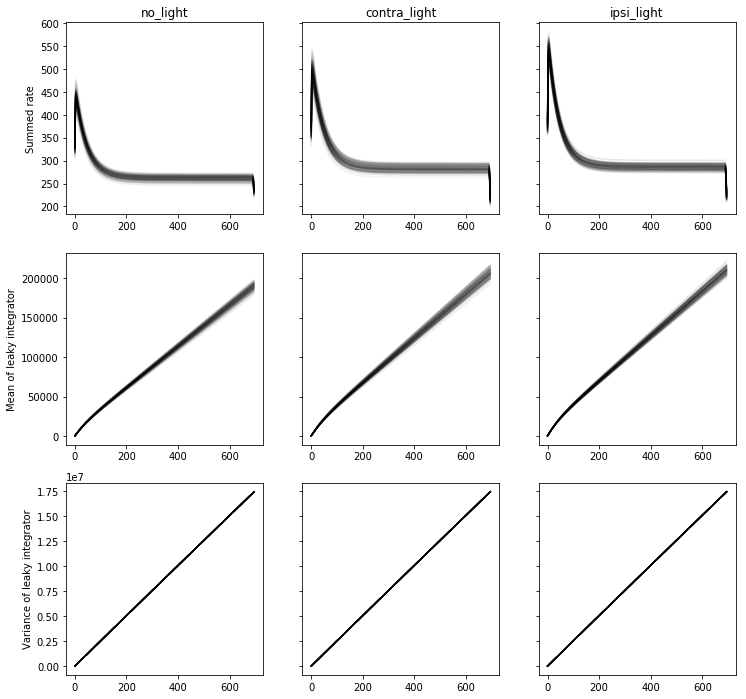

In [84]:
_, axs = plt.subplots(3, 3, figsize=(12, 12), sharex='row', sharey='row')
labels = ['no_light', 'contra_light', 'ipsi_light']
for ax, dd, label in zip(axs[0], d, labels):
    ax.plot(dd.T, 'k', alpha=0.05)
    ax.set_title(label)
axs[0, 0].set_ylabel('Summed rate')
for ax, ll in zip(axs[1], li):
    ax.plot(ll.T, 'k', alpha=0.05)
axs[1, 0].set_ylabel('Mean of leaky integrator')
for ax, ll in zip(axs[2], li_var):
    ax.plot(ll.T, 'k', alpha=0.05)
axs[2, 0].set_ylabel('Variance of leaky integrator')

In [85]:
labels = [
    "no light",
    "contralateral light on first",
    "contralateral light on second",
    "ipsilateral light on first",
    "ipsilateral light on second",
]
indexes = [
    (0, 0),
    (1, 0),
    (0, 1),
    (2, 0),
    (0, 2),
]
colors = [
    'k',
    'orange',
    'b',
    'g',
    'r',
]

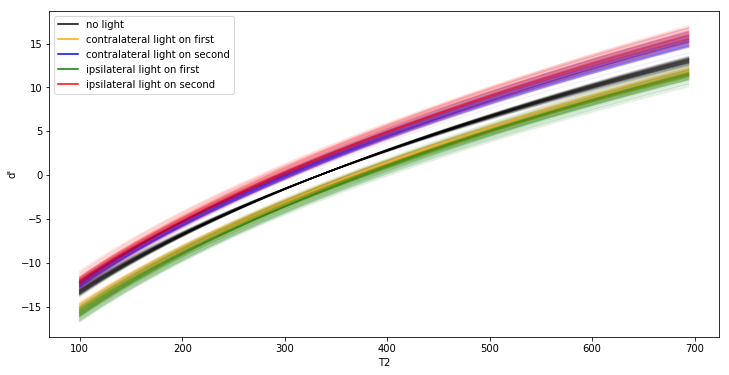

In [86]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
t = np.arange(dprime.shape[-1])
for index, color in zip(indexes, colors):
    ax.plot(t[100:], dprime[index + (slice(None), slice(100, None))].T,
                    '-', color=color, alpha=0.05)
ax.set_ylabel("d'")
ax.set_xlabel("T2")
proxies = [plt.Line2D([], [], color=color)
           for color in colors]
ax.legend(proxies, labels);

In [87]:
def gmean(x, *args, **kwargs):
    return np.exp(np.mean(np.log(x), *args, **kwargs))

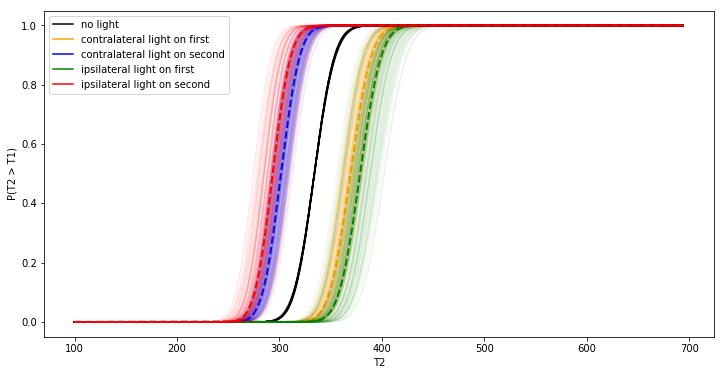

In [88]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
t = np.arange(psychometric.shape[-1])
for index, color in zip(indexes, colors):
    y = psychometric[index + (slice(None), slice(100, None))]
    ax.plot(t[100:], y.T, '-', color=color, alpha=0.05)
    ax.plot(t[100:], np.median(y, axis=0), '--', color=color, linewidth=2)
ax.set_ylabel("P(T2 > T1)")
ax.set_xlabel("T2")
proxies = [plt.Line2D([], [], color=color)
           for color in colors]
ax.legend(proxies, labels);

In [89]:
def pse(t, dprime):
    return np.interp(0, dprime, t)

pse = np.vectorize(pse, signature="(i),(i)->()")
pses = pse(t, dprime)
pses.mean(axis=-1)

array([[334.        , 300.96367898, 292.88747705],
       [369.81503686, 334.        , 325.53738369],
       [379.21600815, 342.70336224, 334.        ]])

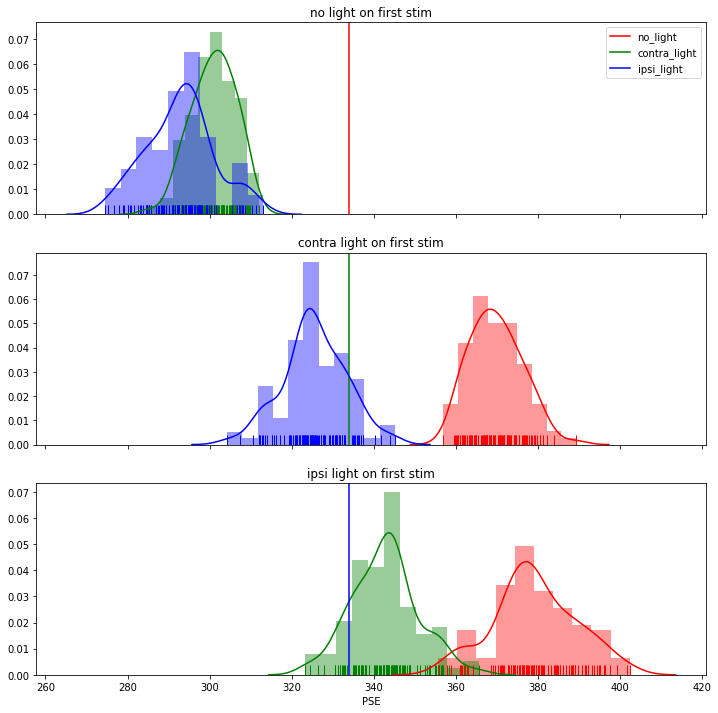

In [90]:
_, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=False)
t = np.arange(psychometric.shape[-1])
colors = ['r', 'g', 'b']
labels = ['no_light', 'contra_light', 'ipsi_light']
for i in range(3):
    for j in range(3):
        color = colors[j]
        if len(np.unique(pses[i, j])) > 1:
            sns.distplot(pses[i, j], color=color, ax=axs[i], rug=True)
        else:
            axs[i].axvline(pses[i, j, 0], color=color)
    axs[i].set_title("{} on first stim".format(labels[i].replace("_", " ")))
axs[2].set_xlabel("PSE")
proxies = [plt.Line2D([], [], color=color)
           for color, label in zip(colors, labels)]
axs[0].legend(proxies, labels);

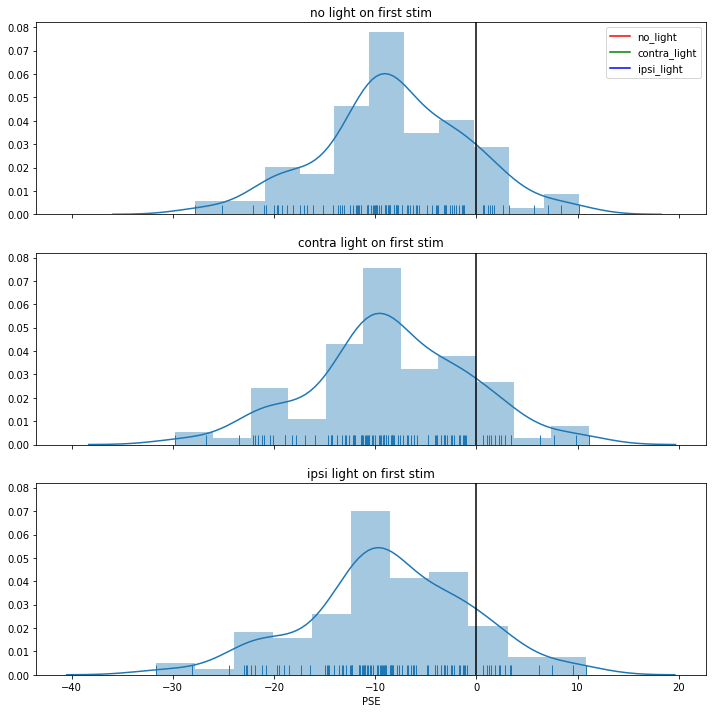

In [91]:
_, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=True)
t = np.arange(psychometric.shape[-1])
colors = ['r', 'g', 'b']
labels = ['no_light', 'contra_light', 'ipsi_light']
for i in range(3):
    sns.distplot(pses[i, 2] - pses[i, 1], ax=axs[i], rug=True)
    axs[i].set_title("{} on first stim".format(labels[i].replace("_", " ")))
    axs[i].axvline(0, color='k')
axs[2].set_xlabel("PSE")
proxies = [plt.Line2D([], [], color=color)
           for color, label in zip(colors, labels)]
axs[0].legend(proxies, labels);

In [57]:
np.mean(pses[:, 2] - pses[:, 1] <= 0, axis=1)

array([0.91, 0.88, 0.88])

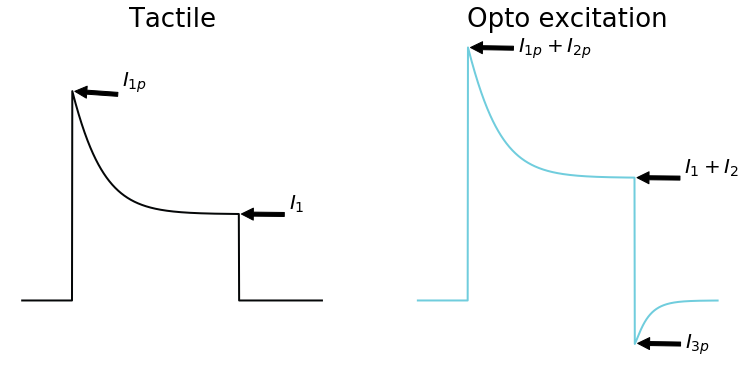

In [46]:
from functools import partial

def fplot(t, I0, I1p, I1, I3p):
    I = np.where(
        np.logical_and(t >= 0, t < 334),
        I1 + (I1p - I1) * np.exp(-t /50),
        np.where(
            t >= 334,
            I3p * np.exp(-(t - 334)/25),
            0.,
        ),
    ) + I0
    return richards(I, nu=44, lam=25)

f1 = partial(fplot, I0=0.5, I1p=3, I1=1, I3p=0)
f2 = partial(fplot, I0=0.5, I1p=4, I1=1.5, I3p=-0.5)


tplot = np.linspace(-100, 500, 1000)
_, axs = plt.subplots(1, 2, figsize=(13, 6), sharey=True, sharex=True)
ax = axs[0]
y1 = f1(tplot)
ax.plot(tplot, y1, color=opto_colormap(0), linewidth=2)
ax.autoscale(axis='x', tight=True)
ax.set_axis_off()

t0 = np.where(tplot >= 0)[0][0]
tend = np.where(tplot >= 334)[0][0]

ax.annotate(
    r'$I_{1p}$',
    xy=(tplot[t0], y1[t0]),
    xytext=(tplot[t0] + 100, y1[t0] + 0.25),
    fontsize=20,
    arrowprops=dict(facecolor='black', shrink=0.05),
)
ax.annotate(
    r'$I_{1}$',
    xy=(tplot[tend - 1], y1[tend - 1]),
    xytext=(tplot[tend - 1] + 100, y1[tend - 1] + 0.25),
    fontsize=20,
    arrowprops=dict(facecolor='black', shrink=0.05),
)
ax.set_title('Tactile', fontsize=26)


ax = axs[1]
y2 = f2(tplot)
ax.plot(tplot, y2, color=opto_colormap(1), linewidth=2)
ax.set_axis_off()
ax.annotate(
    r'$I_{1p} + I_{2p}$',
    xy=(tplot[t0], y2[t0]),
    xytext=(tplot[t0] + 100, y2[t0] - 0.25),
    fontsize=20,
    arrowprops=dict(facecolor='black', shrink=0.05),
)
ax.annotate(
    r'$I_{1} + I_{2}$',
    xy=(tplot[tend - 1], y2[tend - 1]),
    xytext=(tplot[tend - 1] + 100, y2[tend - 1] + 0.25),
    fontsize=20,
    arrowprops=dict(facecolor='black', shrink=0.05),
)
ax.annotate(
    r'$I_{3p}$',
    xy=(tplot[tend + 1], y2[tend + 1]),
    xytext=(tplot[tend + 1] + 100, y2[tend + 1] - 0.25),
    fontsize=20,
    arrowprops=dict(facecolor='black', shrink=0.05),
)
ax.set_title('Opto excitation', fontsize=26);

In [6]:
from compress_pickle import load
import numpy as np
from matplotlib import pyplot as plt

stats = load("simple_model_fits/population_ppc.gz")
stats.index.set_names(["light", "T2", "t"], inplace=True)
stats.loc[:, "_std"] /= np.sqrt(stats.ntrials)
stats

ntrials      _mean          _var      _std
light T2    t                                                 
0     161.0 -300.0   1671.0  20.764924   6197.294015  1.925807
            -290.0   1671.0  20.749753   6178.274623  1.922850
            -280.0   1671.0  20.778194   6179.777866  1.923084
            -270.0   1671.0  20.758303   6176.374263  1.922554
            -260.0   1671.0  20.762635   6185.871761  1.924032
            -250.0   1671.0  20.789804   6191.315202  1.924878
            -240.0   1671.0  20.781598   6181.640778  1.923374
            -230.0   1671.0  20.781014   6182.746880  1.923546
            -220.0   1671.0  20.791210   6187.737533  1.924322
            -210.0   1671.0  20.795818   6194.846588  1.925427
            -200.0   1671.0  20.782780   6194.153726  1.925319
            -190.0   1671.0  20.771297   6183.619214  1.923681
            -180.0   1671.0  20.834268   6216.536568  1.928795
            -170.0   1671.0  20.758610   6167.614520  1.921190
            -160.0   1671.0  20.803942   6195.824137  1.925579
            -150.0   1671.0  20.752932   6159.065756  1.919858
            -140.0   1671.0  20.764654   6172.336839  1.921926
            -130.0   1671.0  20.787148   6194.070150  1.925306
            -120.0   1671.0  20.766569   6187.265628  1.924248
            -110.0   1671.0  20.787111   6182.919653  1.923573
            -100.0   1671.0  20.782204   6187.331790  1.924259
            -90.0    1671.0  20.776668   6180.703367  1.923228
            -80.0    1671.0  20.789856   6185.312620  1.923945
            -70.0    1671.0  20.777521   6180.932276  1.923263
            -60.0    1671.0  20.798063   6201.741237  1.926498
            -50.0    1671.0  20.795048   6193.142438  1.925162
            -40.0    1671.0  20.780618   6179.727746  1.923076
            -30.0    1671.0  20.777723   6180.977872  1.923270
            -20.0    1671.0  20.847509   6209.344034  1.927679
            -10.0    1671.0  24.269636   8144.232330  2.207684
...                     ...        ...           ...       ...
1     694.0  600.0   1507.0  27.322387  11338.366293  2.742955
             610.0   1507.0  27.358436  11371.559217  2.746967
             620.0   1507.0  27.331544  11350.254386  2.744392
             630.0   1507.0  27.345446  11371.038916  2.746904
             640.0   1507.0  27.326891  11343.038892  2.743520
             650.0   1507.0  27.326676  11348.542370  2.744185
             660.0   1507.0  27.348673  11373.301860  2.747177
             670.0   1507.0  27.307299  11343.238531  2.743544
             680.0   1507.0  25.755192   9138.752434  2.462560
             690.0   1507.0  18.847213   5397.142176  1.892454
             700.0   1507.0  15.575133   3838.649878  1.595999
             710.0   1507.0  17.288429   4335.932891  1.696230
             720.0   1507.0  18.804736   4831.038286  1.790456
             730.0   1507.0  19.506760   5008.817601  1.823102
             740.0   1507.0  19.834049   5128.268117  1.844713
             750.0   1507.0  19.952248   5154.298920  1.849389
             760.0   1507.0  20.072130   5192.828215  1.856288
             770.0   1507.0  20.078052   5189.984067  1.855780
             780.0   1507.0  20.148258   5209.410508  1.859249
             790.0   1507.0  20.198507   5222.106124  1.861514
             800.0   1507.0  20.209572   5233.949619  1.863623
             810.0   1507.0  20.248598   5246.844878  1.865918
             820.0   1507.0  20.265710   5237.558117  1.864266
             830.0   1507.0  20.277181   5234.177884  1.863664
             840.0   1507.0  20.304944   5253.915807  1.867175
             850.0   1507.0  20.331768   5263.727178  1.868917
             860.0   1507.0  20.354471   5259.978515  1.868252
             870.0   1507.0  20.354944   5262.072915  1.868623
             880.0   1507.0  20.372901   5255.855121  1.867519
             890.0   1507.0  20.376908   5261.006070  1.868434

[1234 rows x 4 columns]

In [35]:
plot_df = stacked_df.query("T2 == 334").groupby(["light", "t"])["ntrials", "psth"].sum()
t = plot_df.index.unique(1)
plot_df.loc[:, "psth"] /= plot_df.ntrials / 100

(-300.0, 530.0, 12.9472574688467, 48.74957443553151)

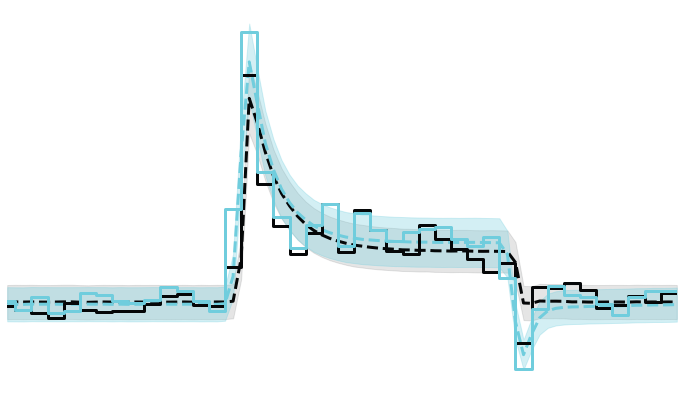

In [45]:
loff = stats.xs((0, 334))
lon = stats.xs((1, 334))
coff = opto_colormap(0)
con = opto_colormap(1)

plt.figure(figsize=(12, 7))
plt.plot(loff.index, loff._mean, color=coff, linestyle="--")
plt.fill_between(loff.index, loff._mean + loff._std, loff._mean - loff._std, color=coff, alpha=0.1)
plt.plot(lon.index, lon._mean, color=con, linestyle="--")
plt.fill_between(lon.index, lon._mean + lon._std, lon._mean - lon._std, color=con, alpha=0.3)
dloff, dlon = plot_df.reset_index().groupby(["light"])["psth"].apply(increase_psth_binsize)
plt.step(t, dloff, color=coff)
plt.step(t, dlon, color=con, linewidth=2)
plt.autoscale(enable=True, axis='x', tight=True)
[l.set_linewidth(3) for l in plt.gca().get_lines()];
plt.axis("off")

(-49.95, 1048.95, -0.15707003000687392, 3.298470630144352)

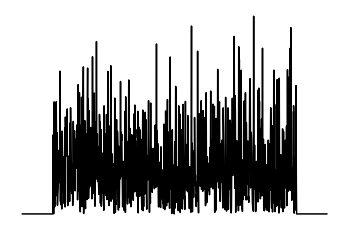

In [89]:
y = np.abs(np.random.randn(1000))
y[:100] = 0
y[-100:] = 0

plt.plot(y, color="k")
plt.axis('off')